# Archaic admixture in swept and non-swept haplotypes and regions

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}


def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [5]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

## Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

## Sweep and admixture data

In [9]:
admix_windows_chrX = pandas.read_hdf(results_dir / 'male_x_admix_windows.hdf')
admix_windows_chrX.head()

,chrom,name,start,end,admix_prop,nr_admix_tracts,archaic_snps,vindija_snps,tot_admix_len,denisova_snps,altai_snps,mean_post_prob,level_1,bases_analyzed
0,X,B_Australian-4,0,100000,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,1337
1,X,B_Australian-4,100000,200000,NaN,0,NaN,NaN,0,NaN,NaN,NaN,1,5045
2,X,B_Australian-4,200000,300000,NaN,0,NaN,NaN,0,NaN,NaN,NaN,2,9875
3,X,B_Australian-4,300000,400000,0.0,0,0.0,0.0,0,0.0,0.0,NaN,3,26649
4,X,B_Australian-4,400000,500000,0.0,0,0.0,0.0,0,0.0,0.0,NaN,4,22968


In [10]:
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

merged_data = (sweep_data.merge(admix_windows_chrX, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

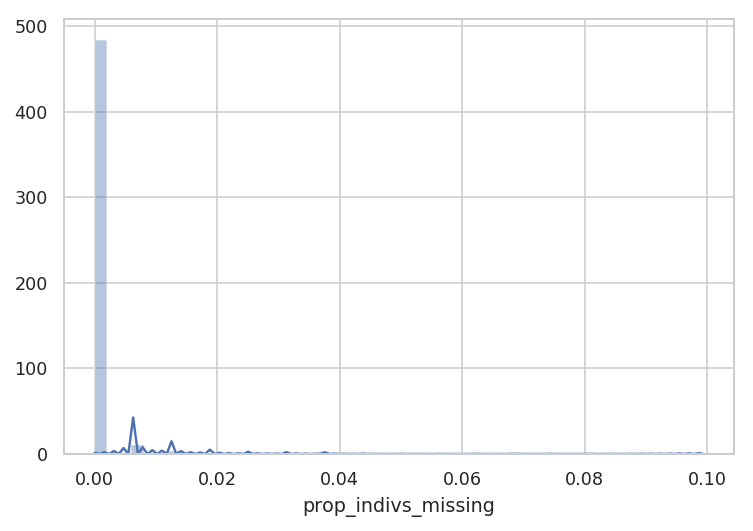

In [11]:
g = sns.distplot(merged_data.prop_indivs_missing)

## Global admixture proportions

In [12]:
merged_data.loc[lambda df: df.region_1 != 'Africa', 'admix_prop'].mean()

0.0080504436847978183

In [13]:
merged_data.groupby('region_1')['admix_prop'].mean()

region_1
Africa                     NaN
WestEurasia           0.006498
SouthAsia             0.008298
CentralAsiaSiberia    0.004931
Oceania               0.014618
EastAsia              0.008455
America               0.005812
Name: admix_prop, dtype: float64

In [14]:
merged_data.head()

,indiv_1,start,end,pop_1,region_label_1,region_id_1,region_1,mean_dist,mean_dist_af,mean_dist_to_africans,...,admix_prop,nr_admix_tracts,archaic_snps,vindija_snps,tot_admix_len,denisova_snps,altai_snps,mean_post_prob,level_1,bases_analyzed
27,B_Australian-4,2700000,2800000,Australian,Oceania,4,Oceania,0.001051,0.001051,0.001735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,27.0,31236.0
28,B_Australian-4,2800000,2900000,Australian,Oceania,4,Oceania,0.000633,0.000623,0.001109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,28.0,27918.0
29,B_Australian-4,2900000,3000000,Australian,Oceania,4,Oceania,0.000377,0.000318,0.000844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,29.0,31151.0
30,B_Australian-4,3000000,3100000,Australian,Oceania,4,Oceania,0.001087,0.001087,0.001078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,30.0,41200.0
31,B_Australian-4,3100000,3200000,Australian,Oceania,4,Oceania,0.001212,0.001205,0.001544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.0,45155.0


## Admixture segments across the X chromosome

In [15]:
extended_peak_regions_10 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')


In [16]:
plot_df = merged_data.loc[~merged_data.region_1.isin(['Africa']),
                    ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
plot_df['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
                      ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
plot_df.reset_index(inplace=True)
plot_df = stairs(plot_df)
plot_df.head()

,start,end,admix_prop,admix_prop_not_sweept,pos
0,2700000,2800000,0.000000,0.000000,2700000
0,2700000,2800000,0.000000,0.000000,2800000
1,2800000,2900000,0.005429,0.005429,2800000
1,2800000,2900000,0.005429,0.005429,2900000
2,2900000,3000000,0.053143,0.053143,2900000


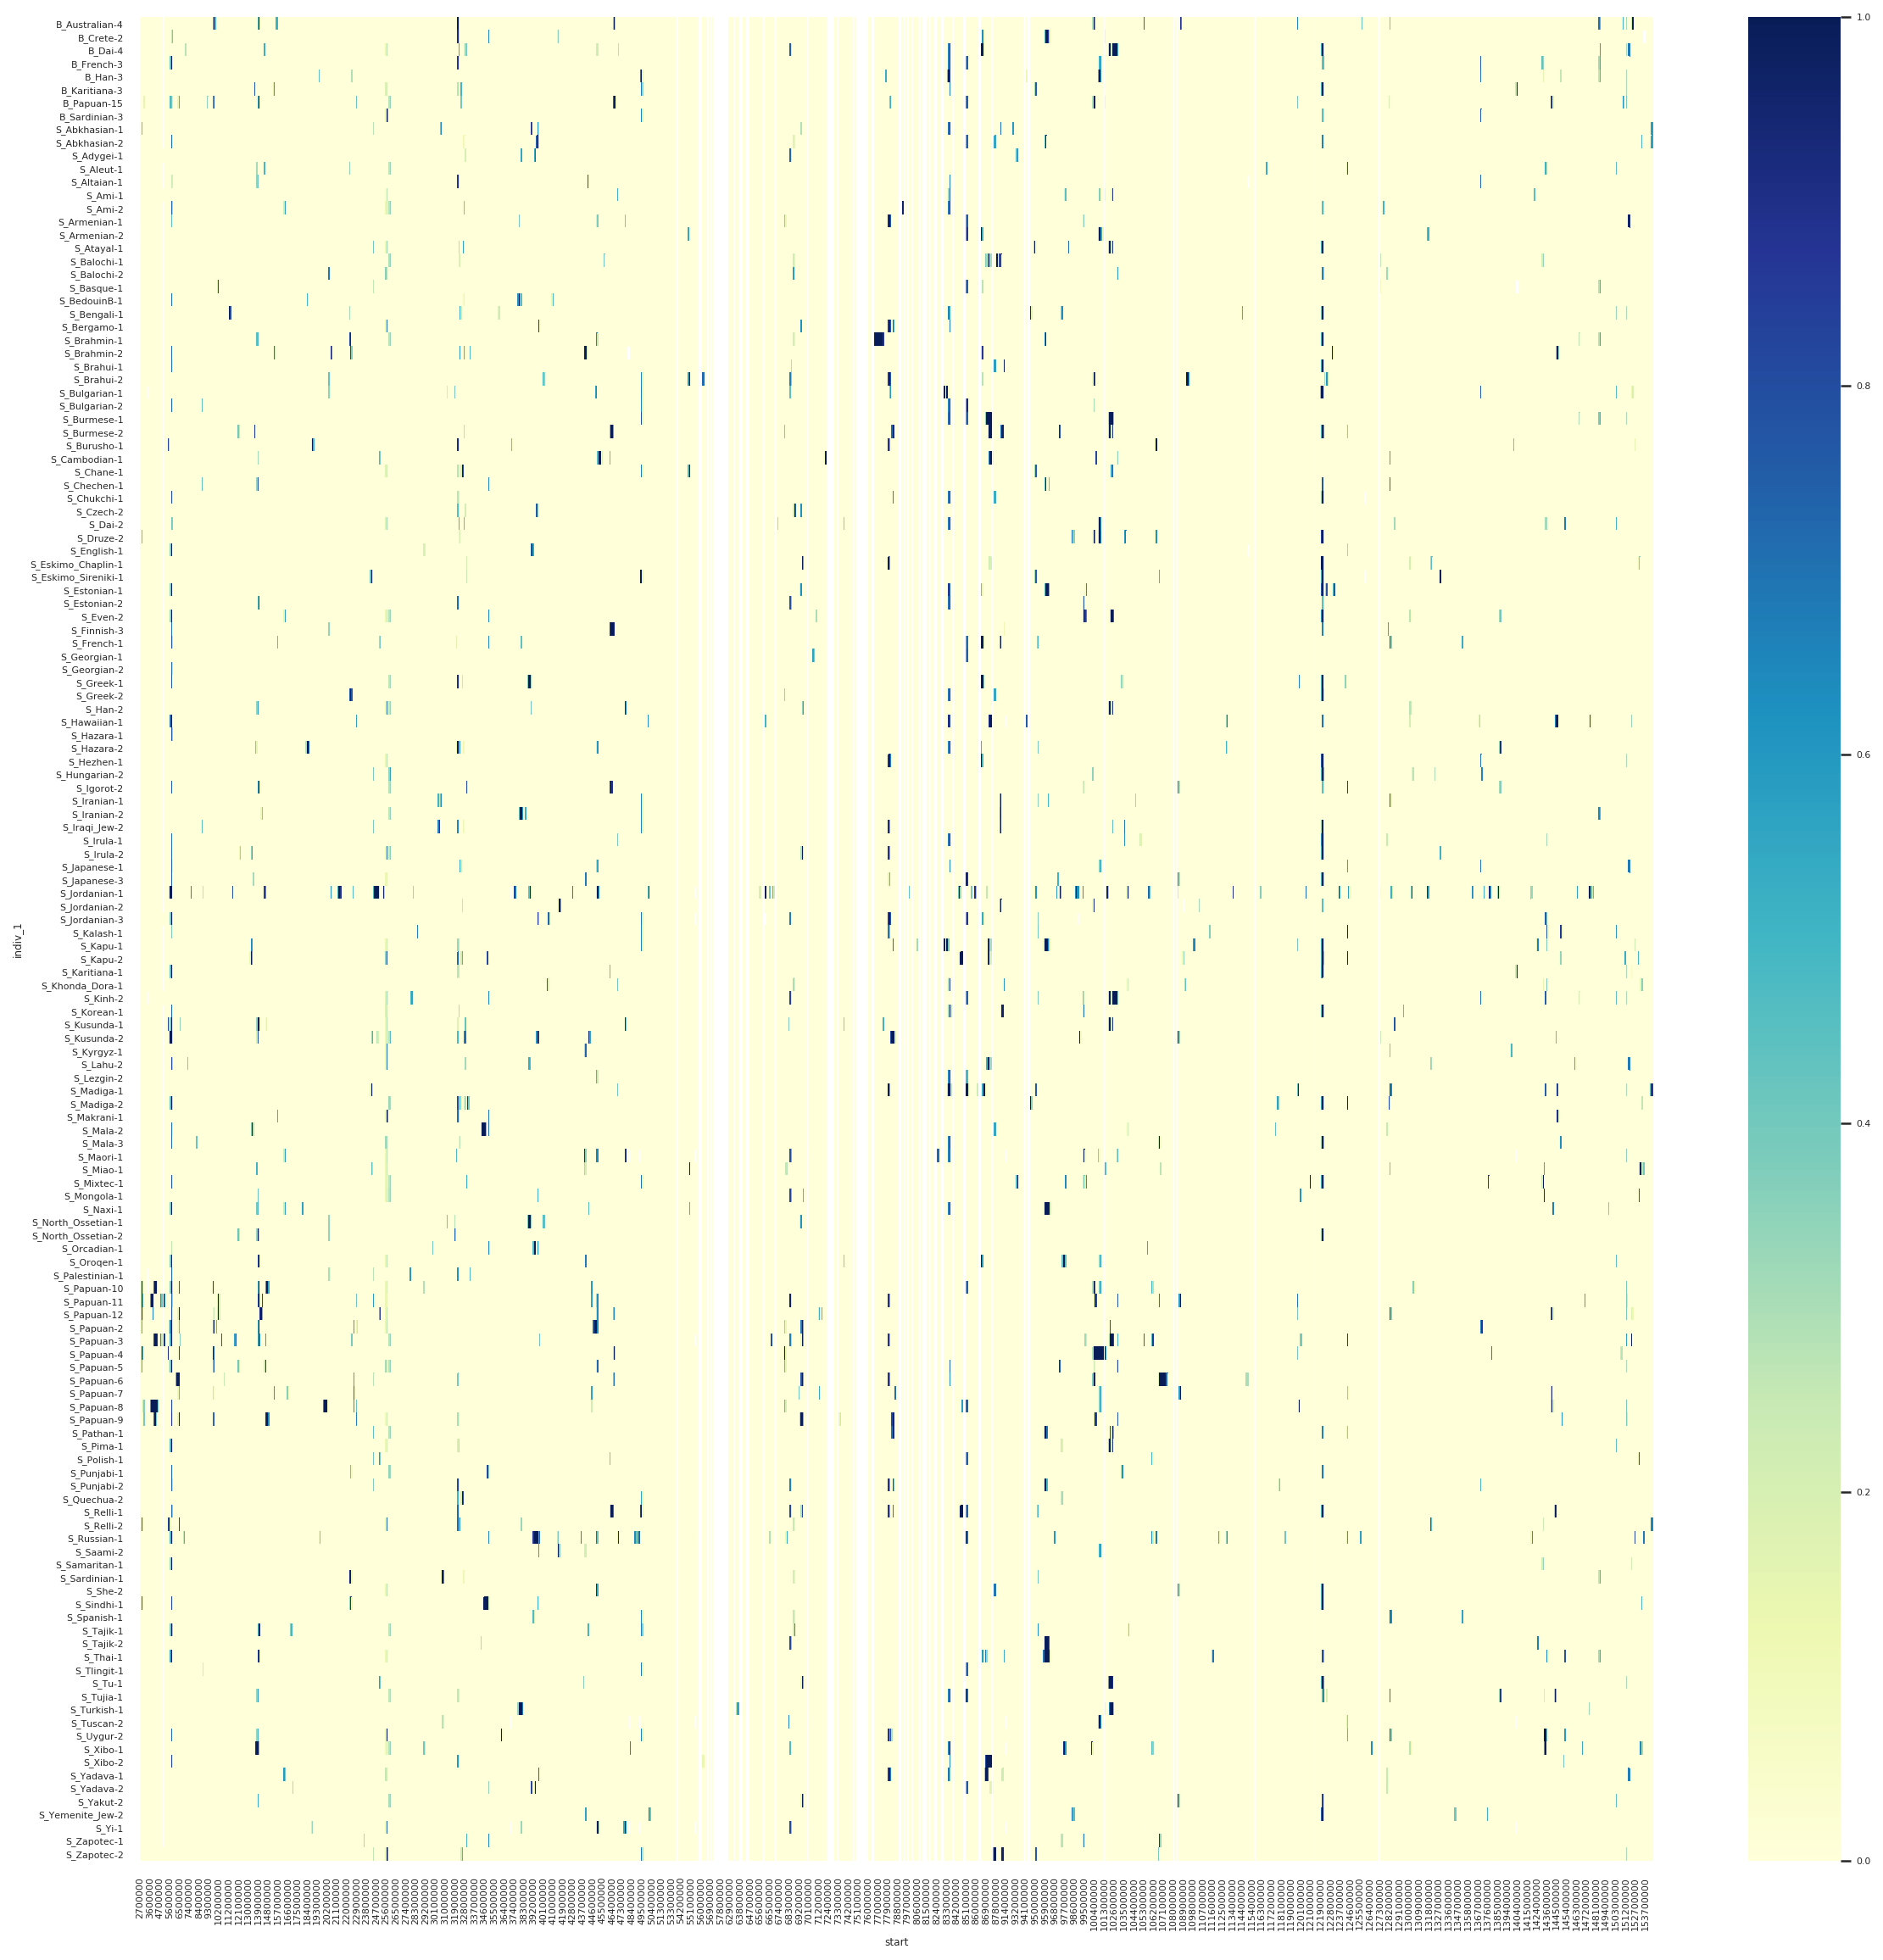

In [17]:
with sns.plotting_context('notebook', font_scale=0.5):
    plt.figure(figsize=(20, 20))
    sns.heatmap(merged_data.loc[merged_data.region_1 != 'Africa'].pivot('indiv_1', 'start', 'admix_prop'), cmap="YlGnBu")

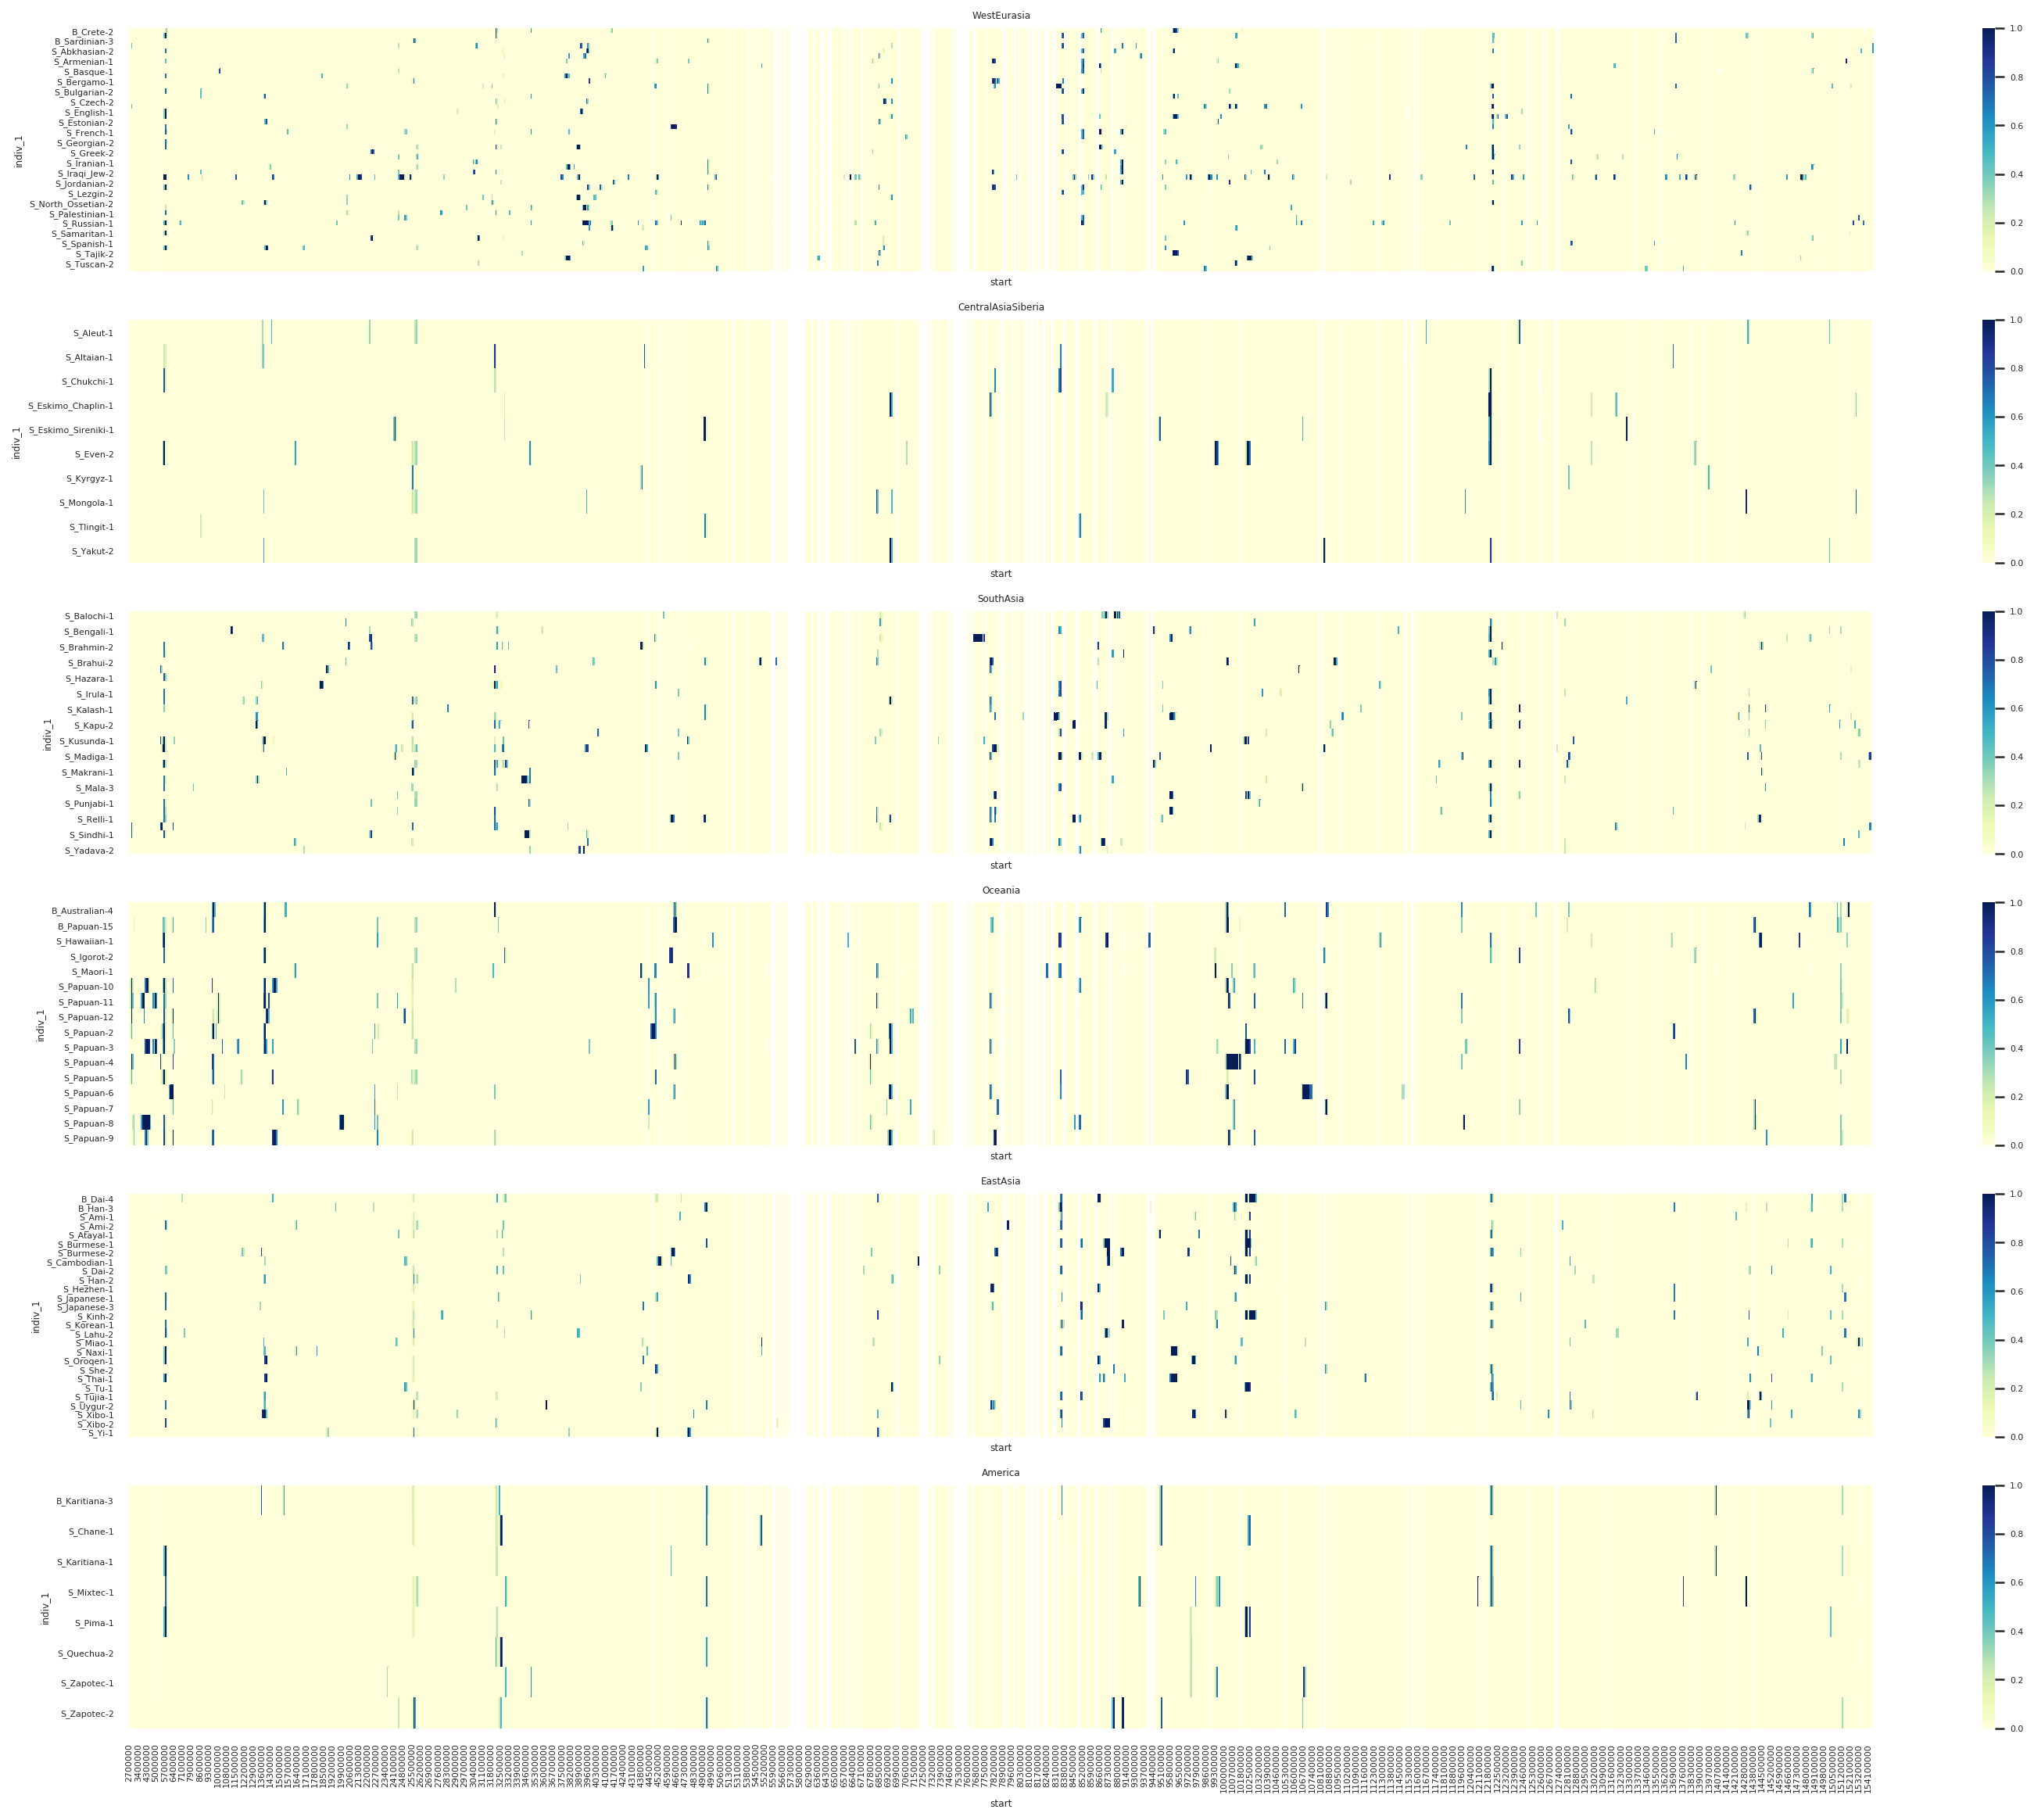

In [18]:
with sns.plotting_context('notebook', font_scale=0.5):
    fig, axes = plt.subplots(6, 1, figsize=(25,20), sharex=True)
    for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
        df = merged_data.loc[merged_data.region_label_1 == region]
        table = df.pivot('indiv_1', 'start', 'admix_prop')
        ax = sns.heatmap(table, ax=axes[i], cmap="YlGnBu")
        axes[i].set_title(region)

## Admixture proportions across the X chromosome

Admixture and 75% regions:

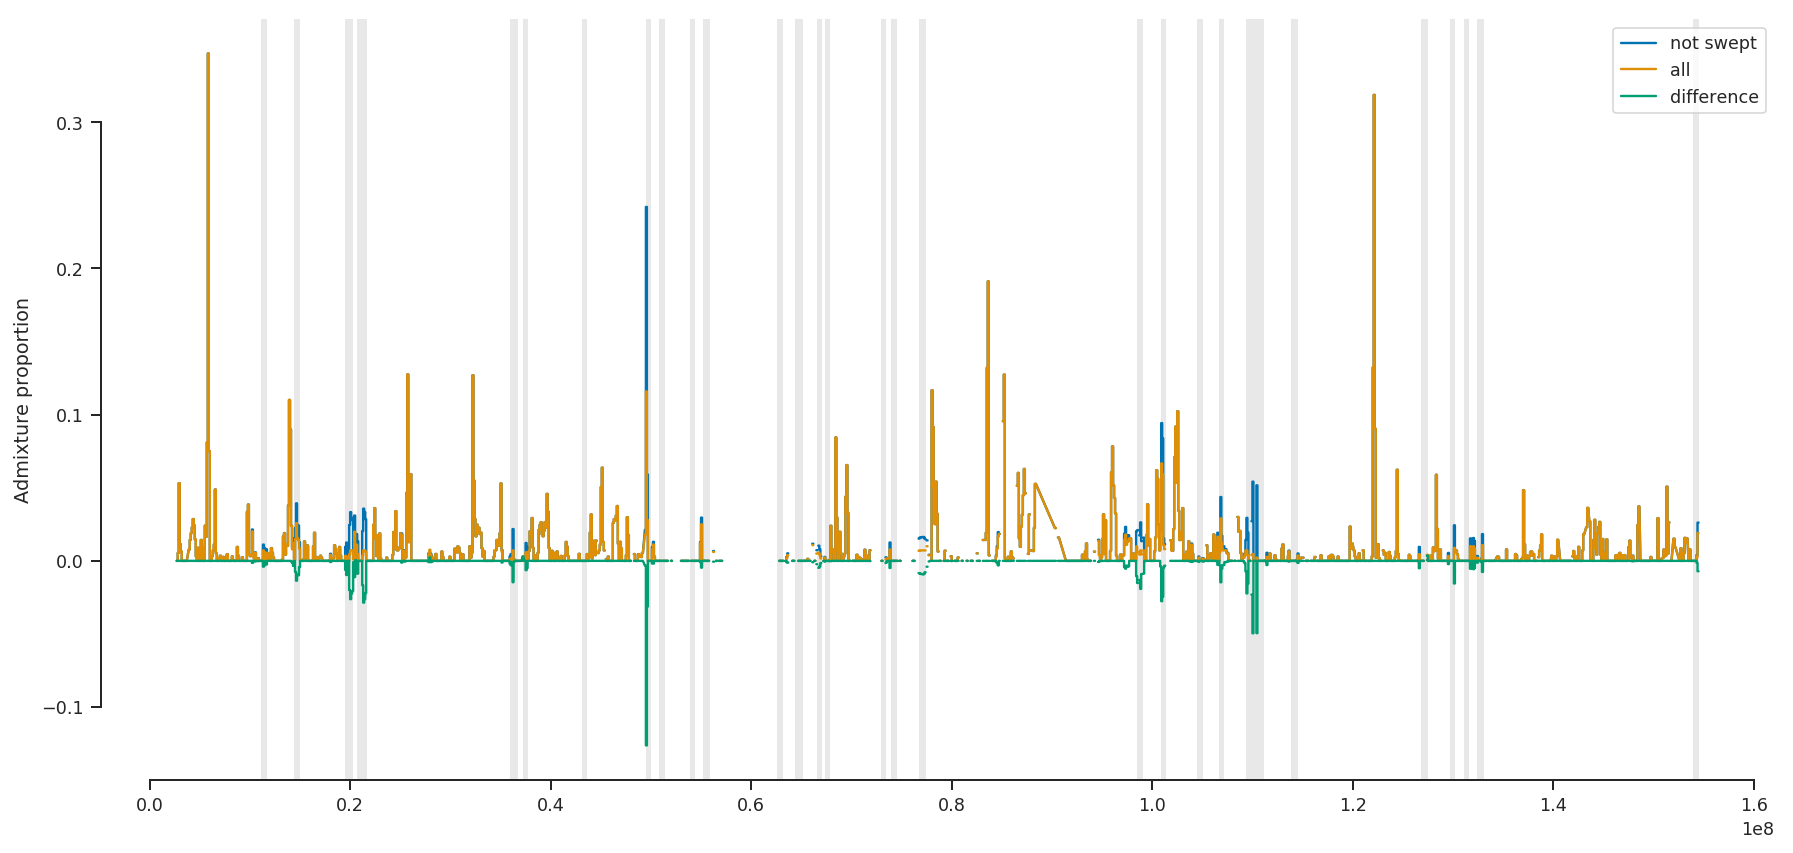

In [19]:
with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, ax1 = plt.subplots(1, 1, figsize=(15,7))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_75.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            
        sns.despine(trim=True)

## Relative reduction in regions with sweeps 


It seems that most regions have depletions but 

# FIGURE OUT WHY THERE ARE SO MANY GAPS IN THE SWEPT REGIONS...

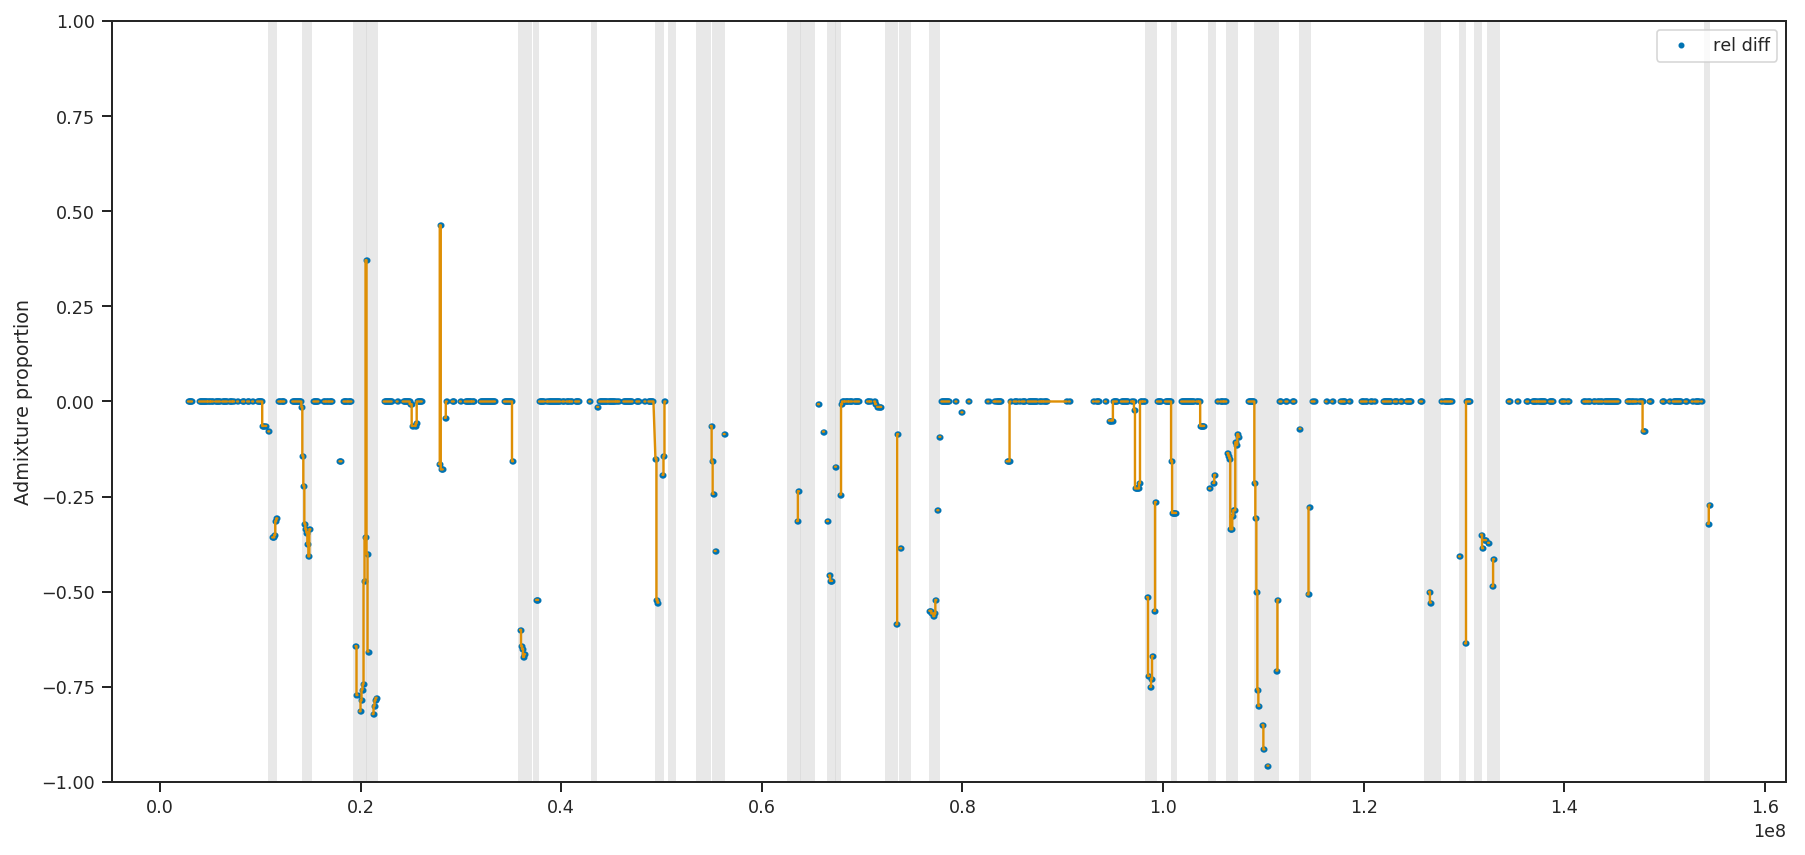

In [32]:
with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, ax1 = plt.subplots(1, 1, figsize=(15,7))
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept, 
                 label='rel diff', marker='o', markersize=2, linestyle='none')
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            
#        sns.despine(trim=True)
        ax1.set_ylim(-1, 1)

Admixture and ILS, ampl. regions and 10% regions:

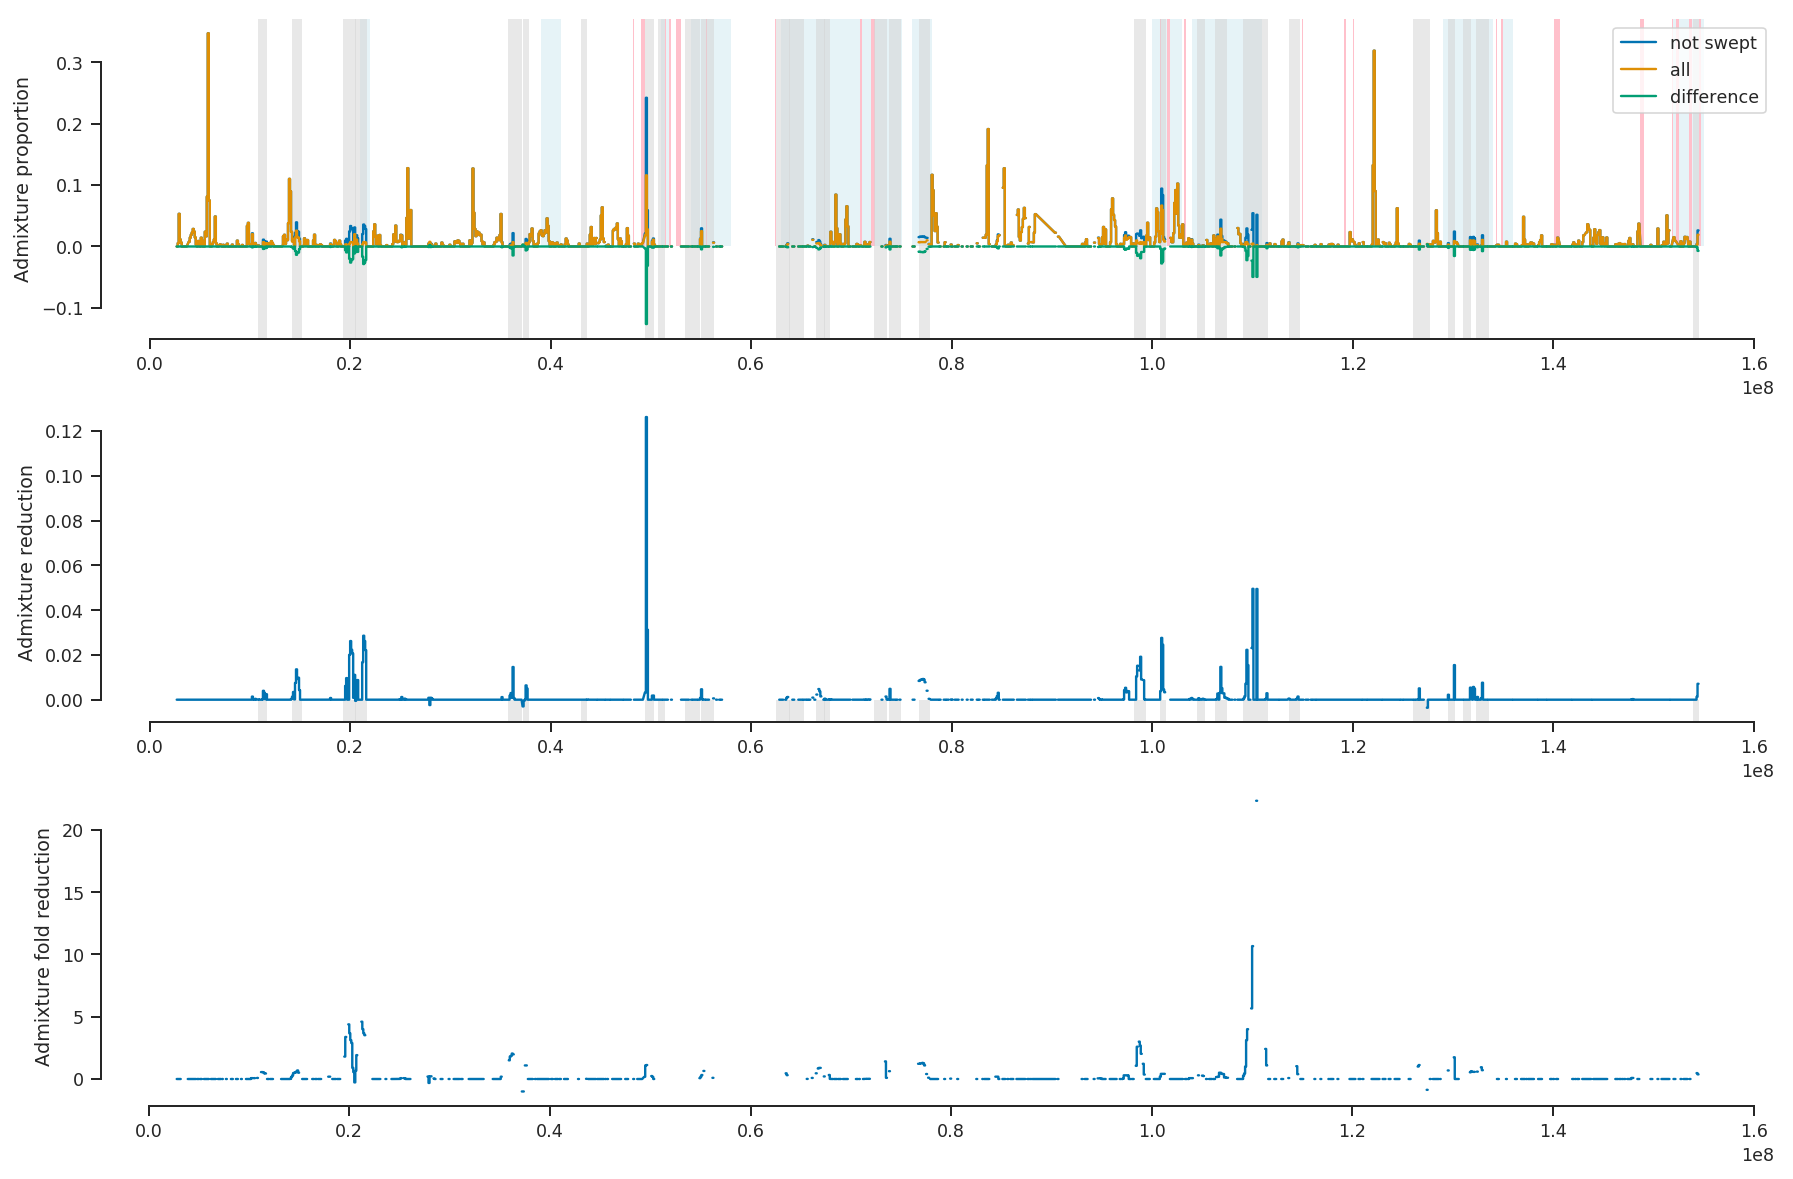

In [20]:
with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')
        
        ax2.plot(plot_df.pos, plot_df.admix_prop_not_sweept - plot_df.admix_prop)
        ax2.set_ylabel('Admixture reduction')

        ax3.plot(plot_df.pos, (plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop)
        ax3.set_ylabel('Admixture fold reduction')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 1, 
                 facecolor='lightgray', 
                 linewidth=0,
        #              edgecolor=None,
                 alpha=0.5,
                 zorder=1))
            
        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='lightblue',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
            
        for tup in ampliconic_regions.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='pink',
                         linewidth=0,
                         alpha=1,
                         zorder=0))            
            
            
        sns.despine(trim=True)
#mpld3.display() 

In [21]:
#mpld3.display(fig)        

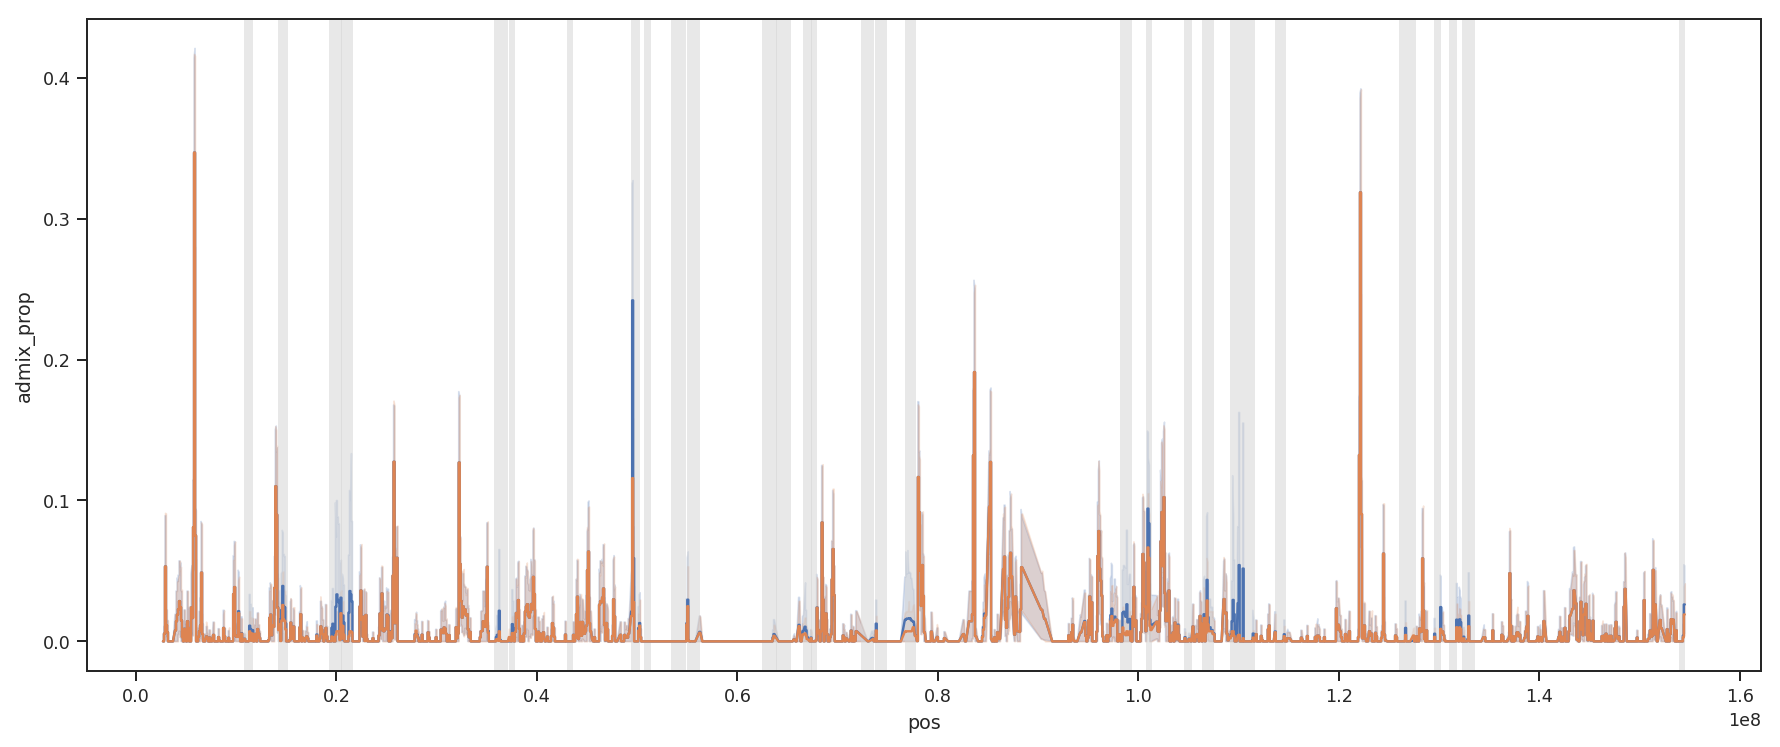

In [22]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))

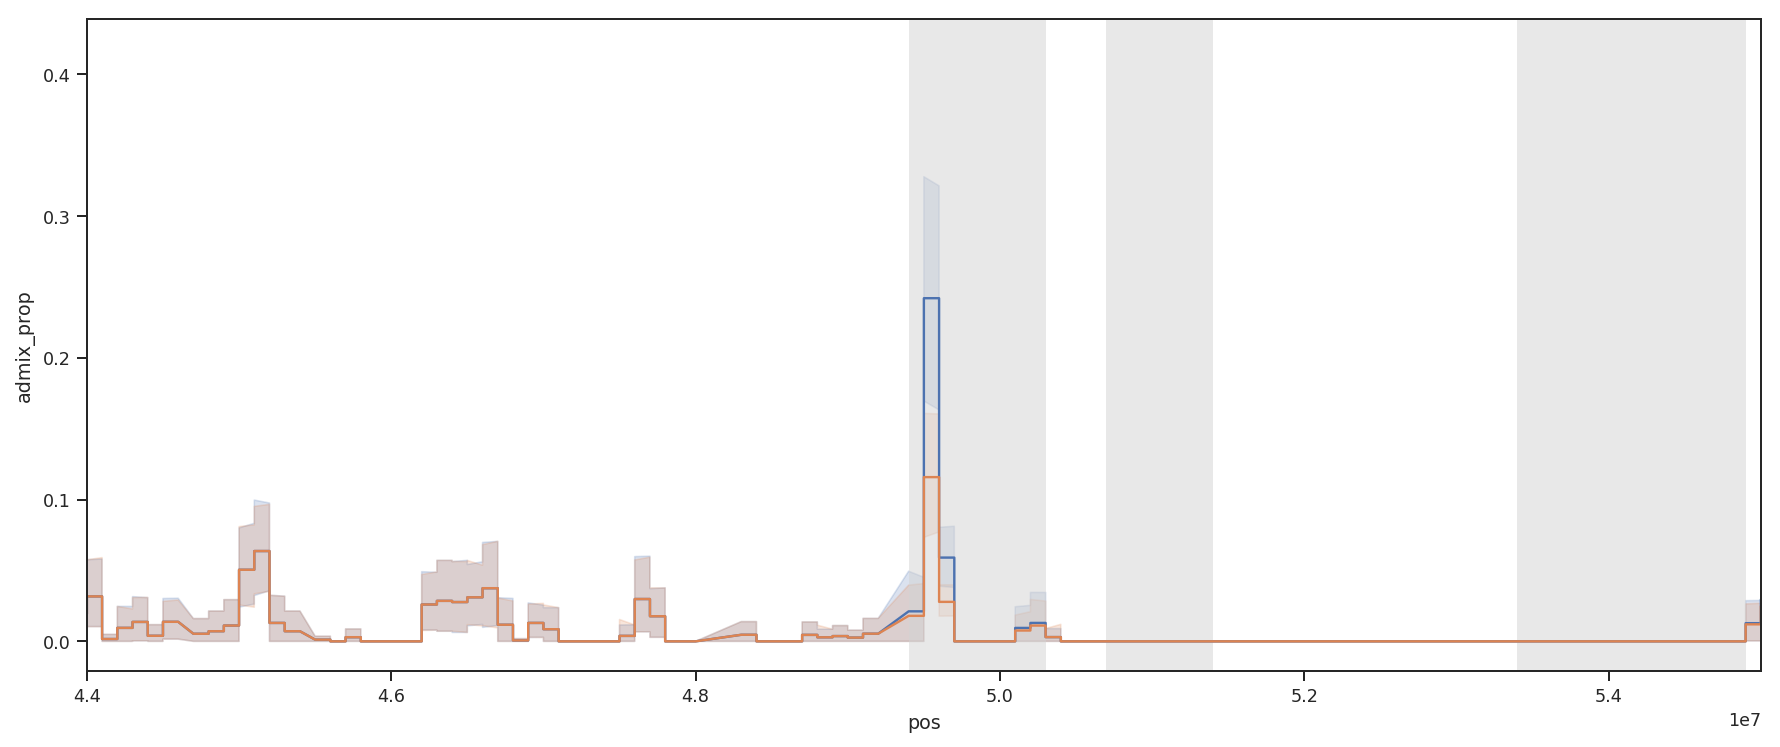

In [23]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_xlim(44e6, 55e6)

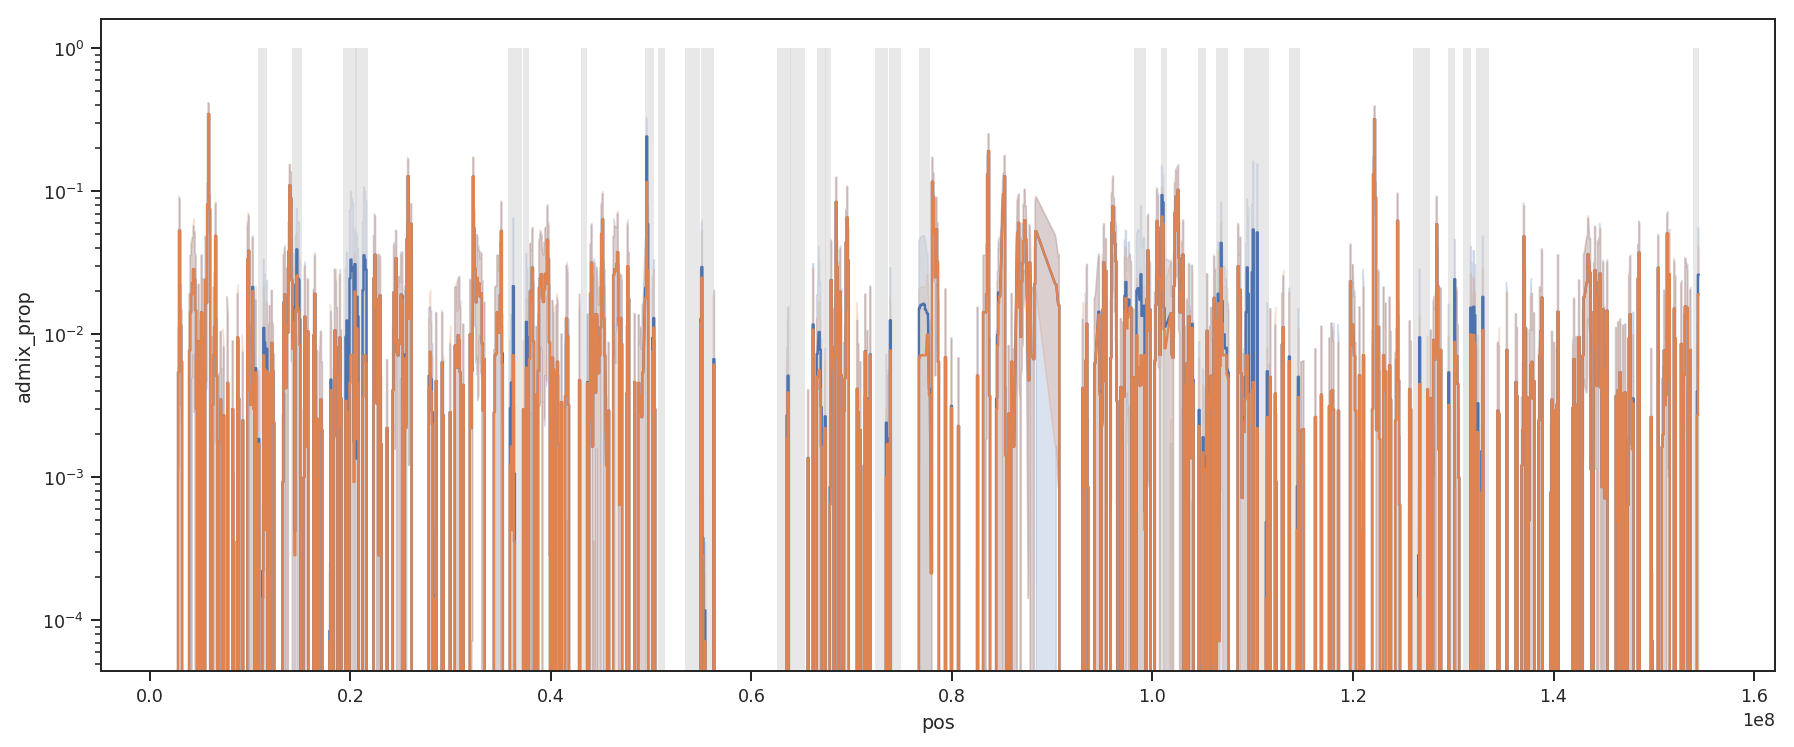

In [24]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_yscale('log')

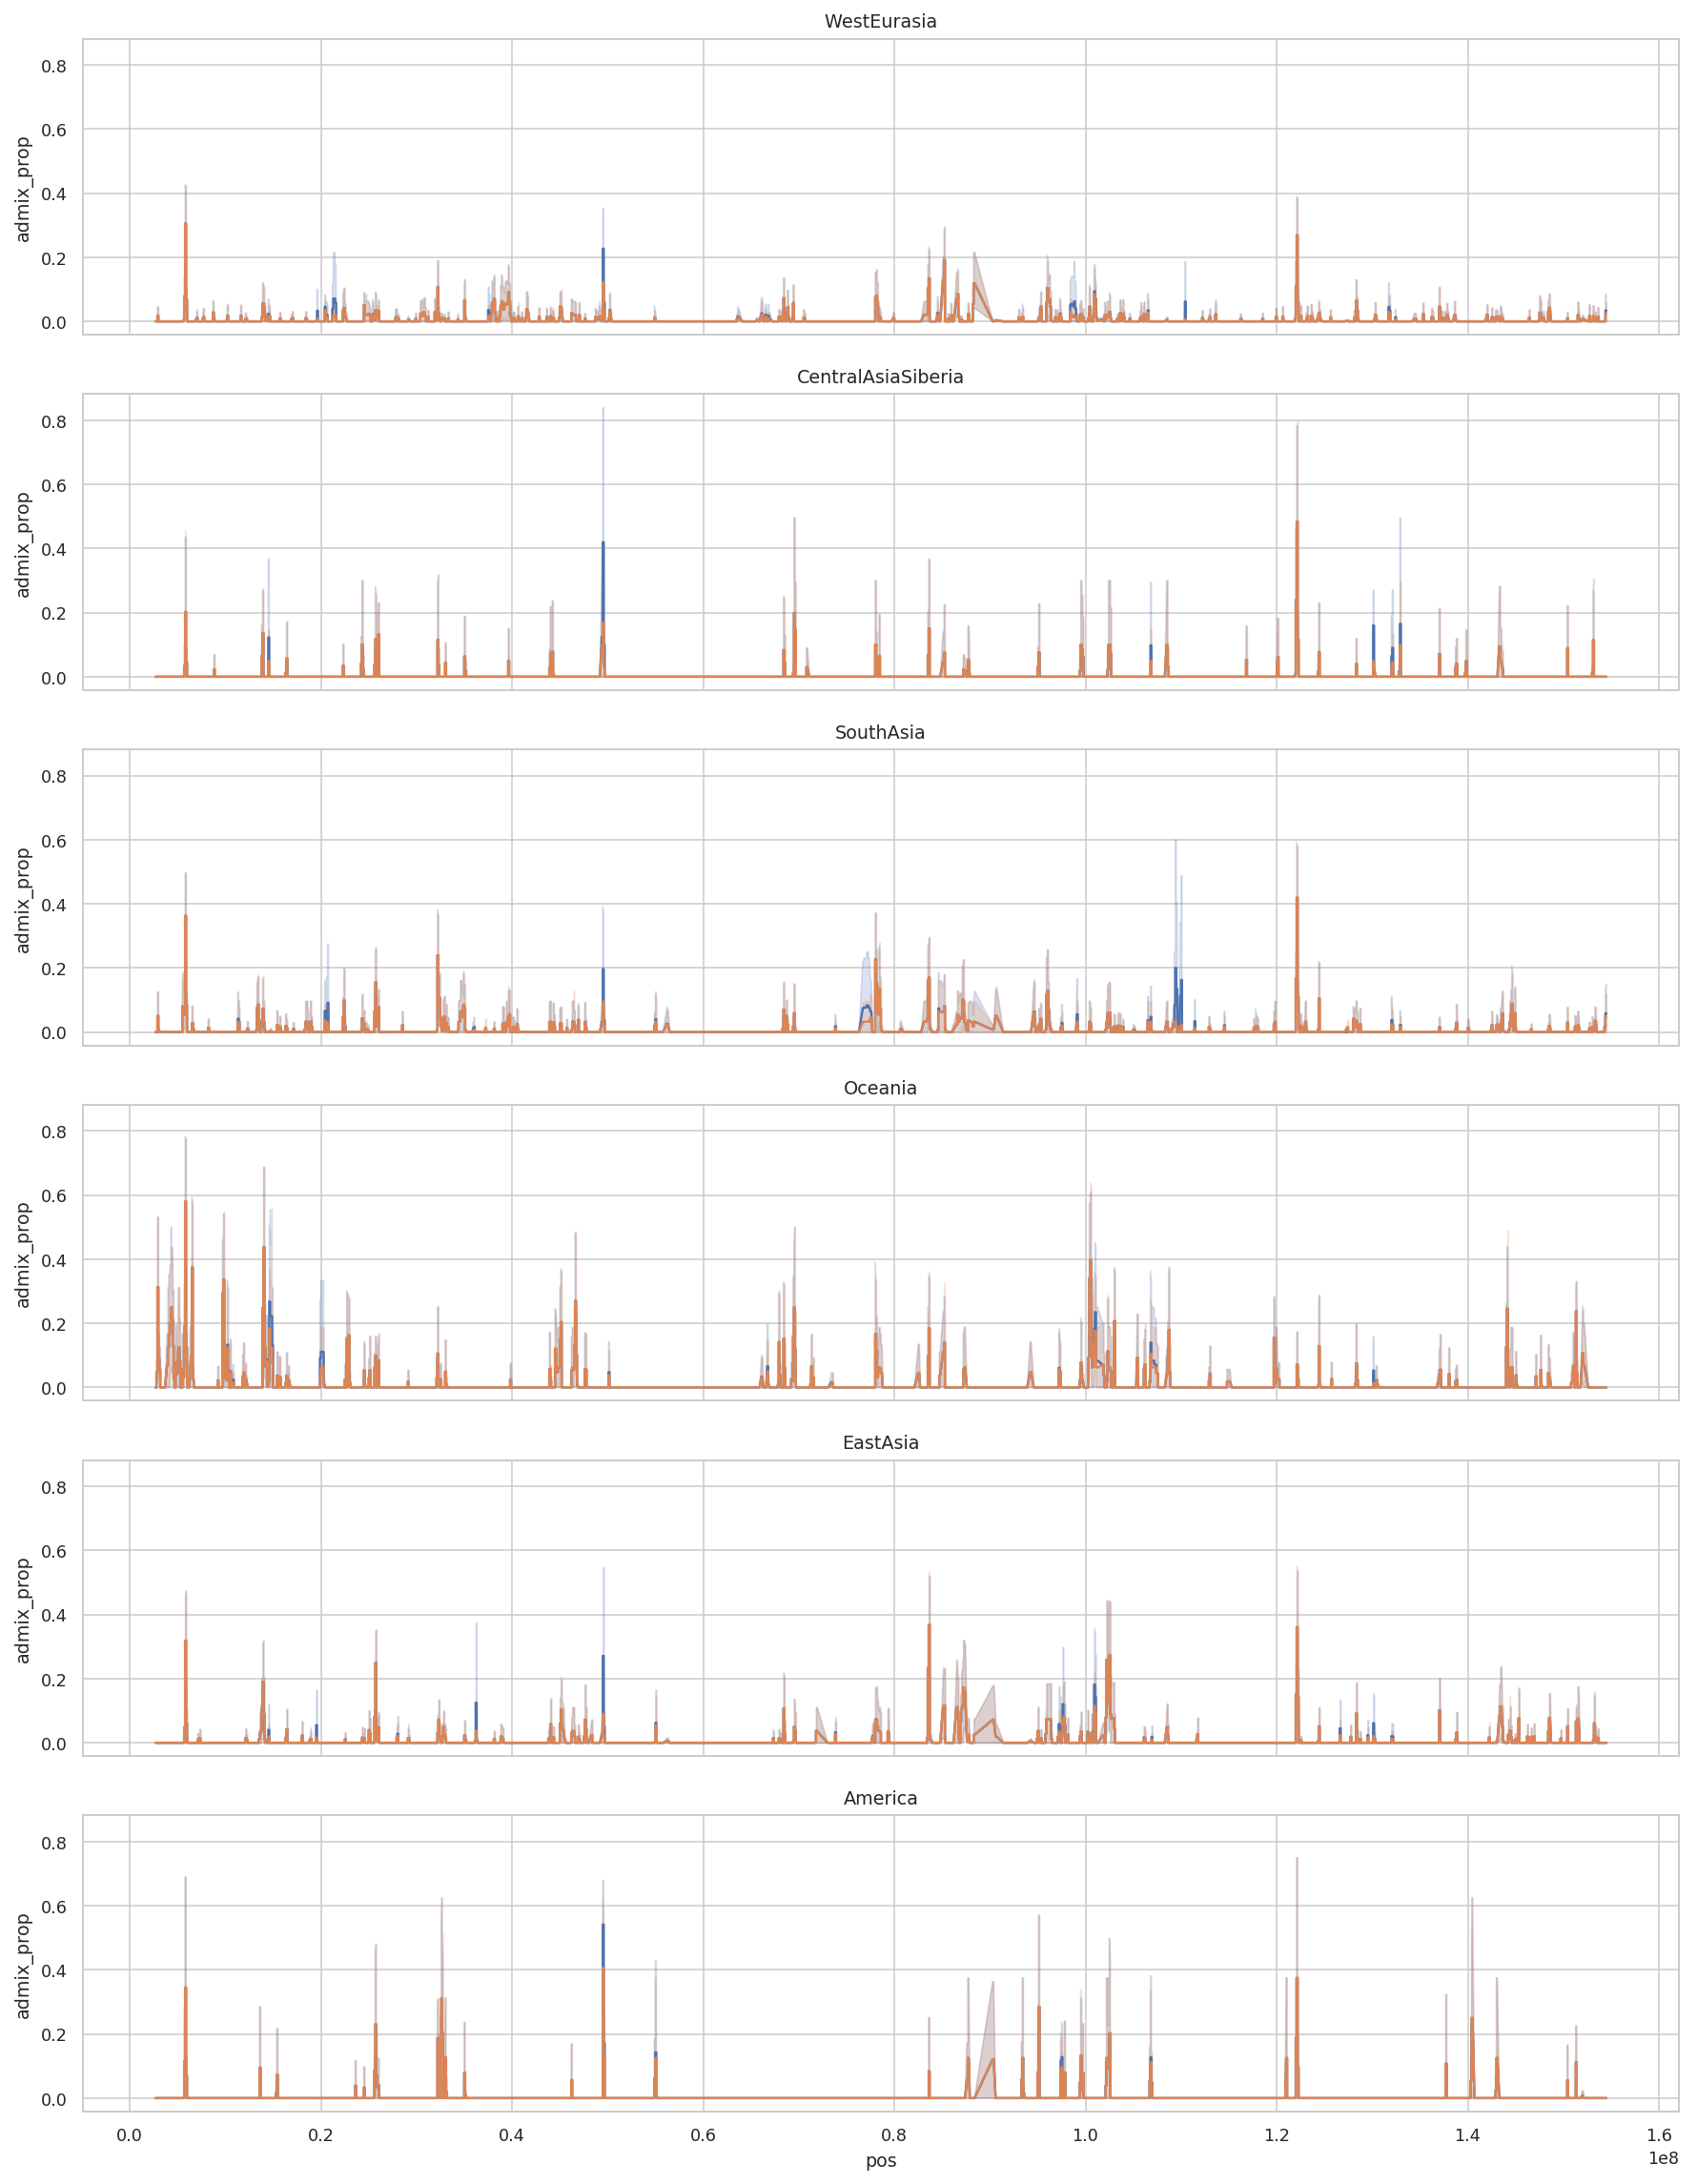

In [25]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])

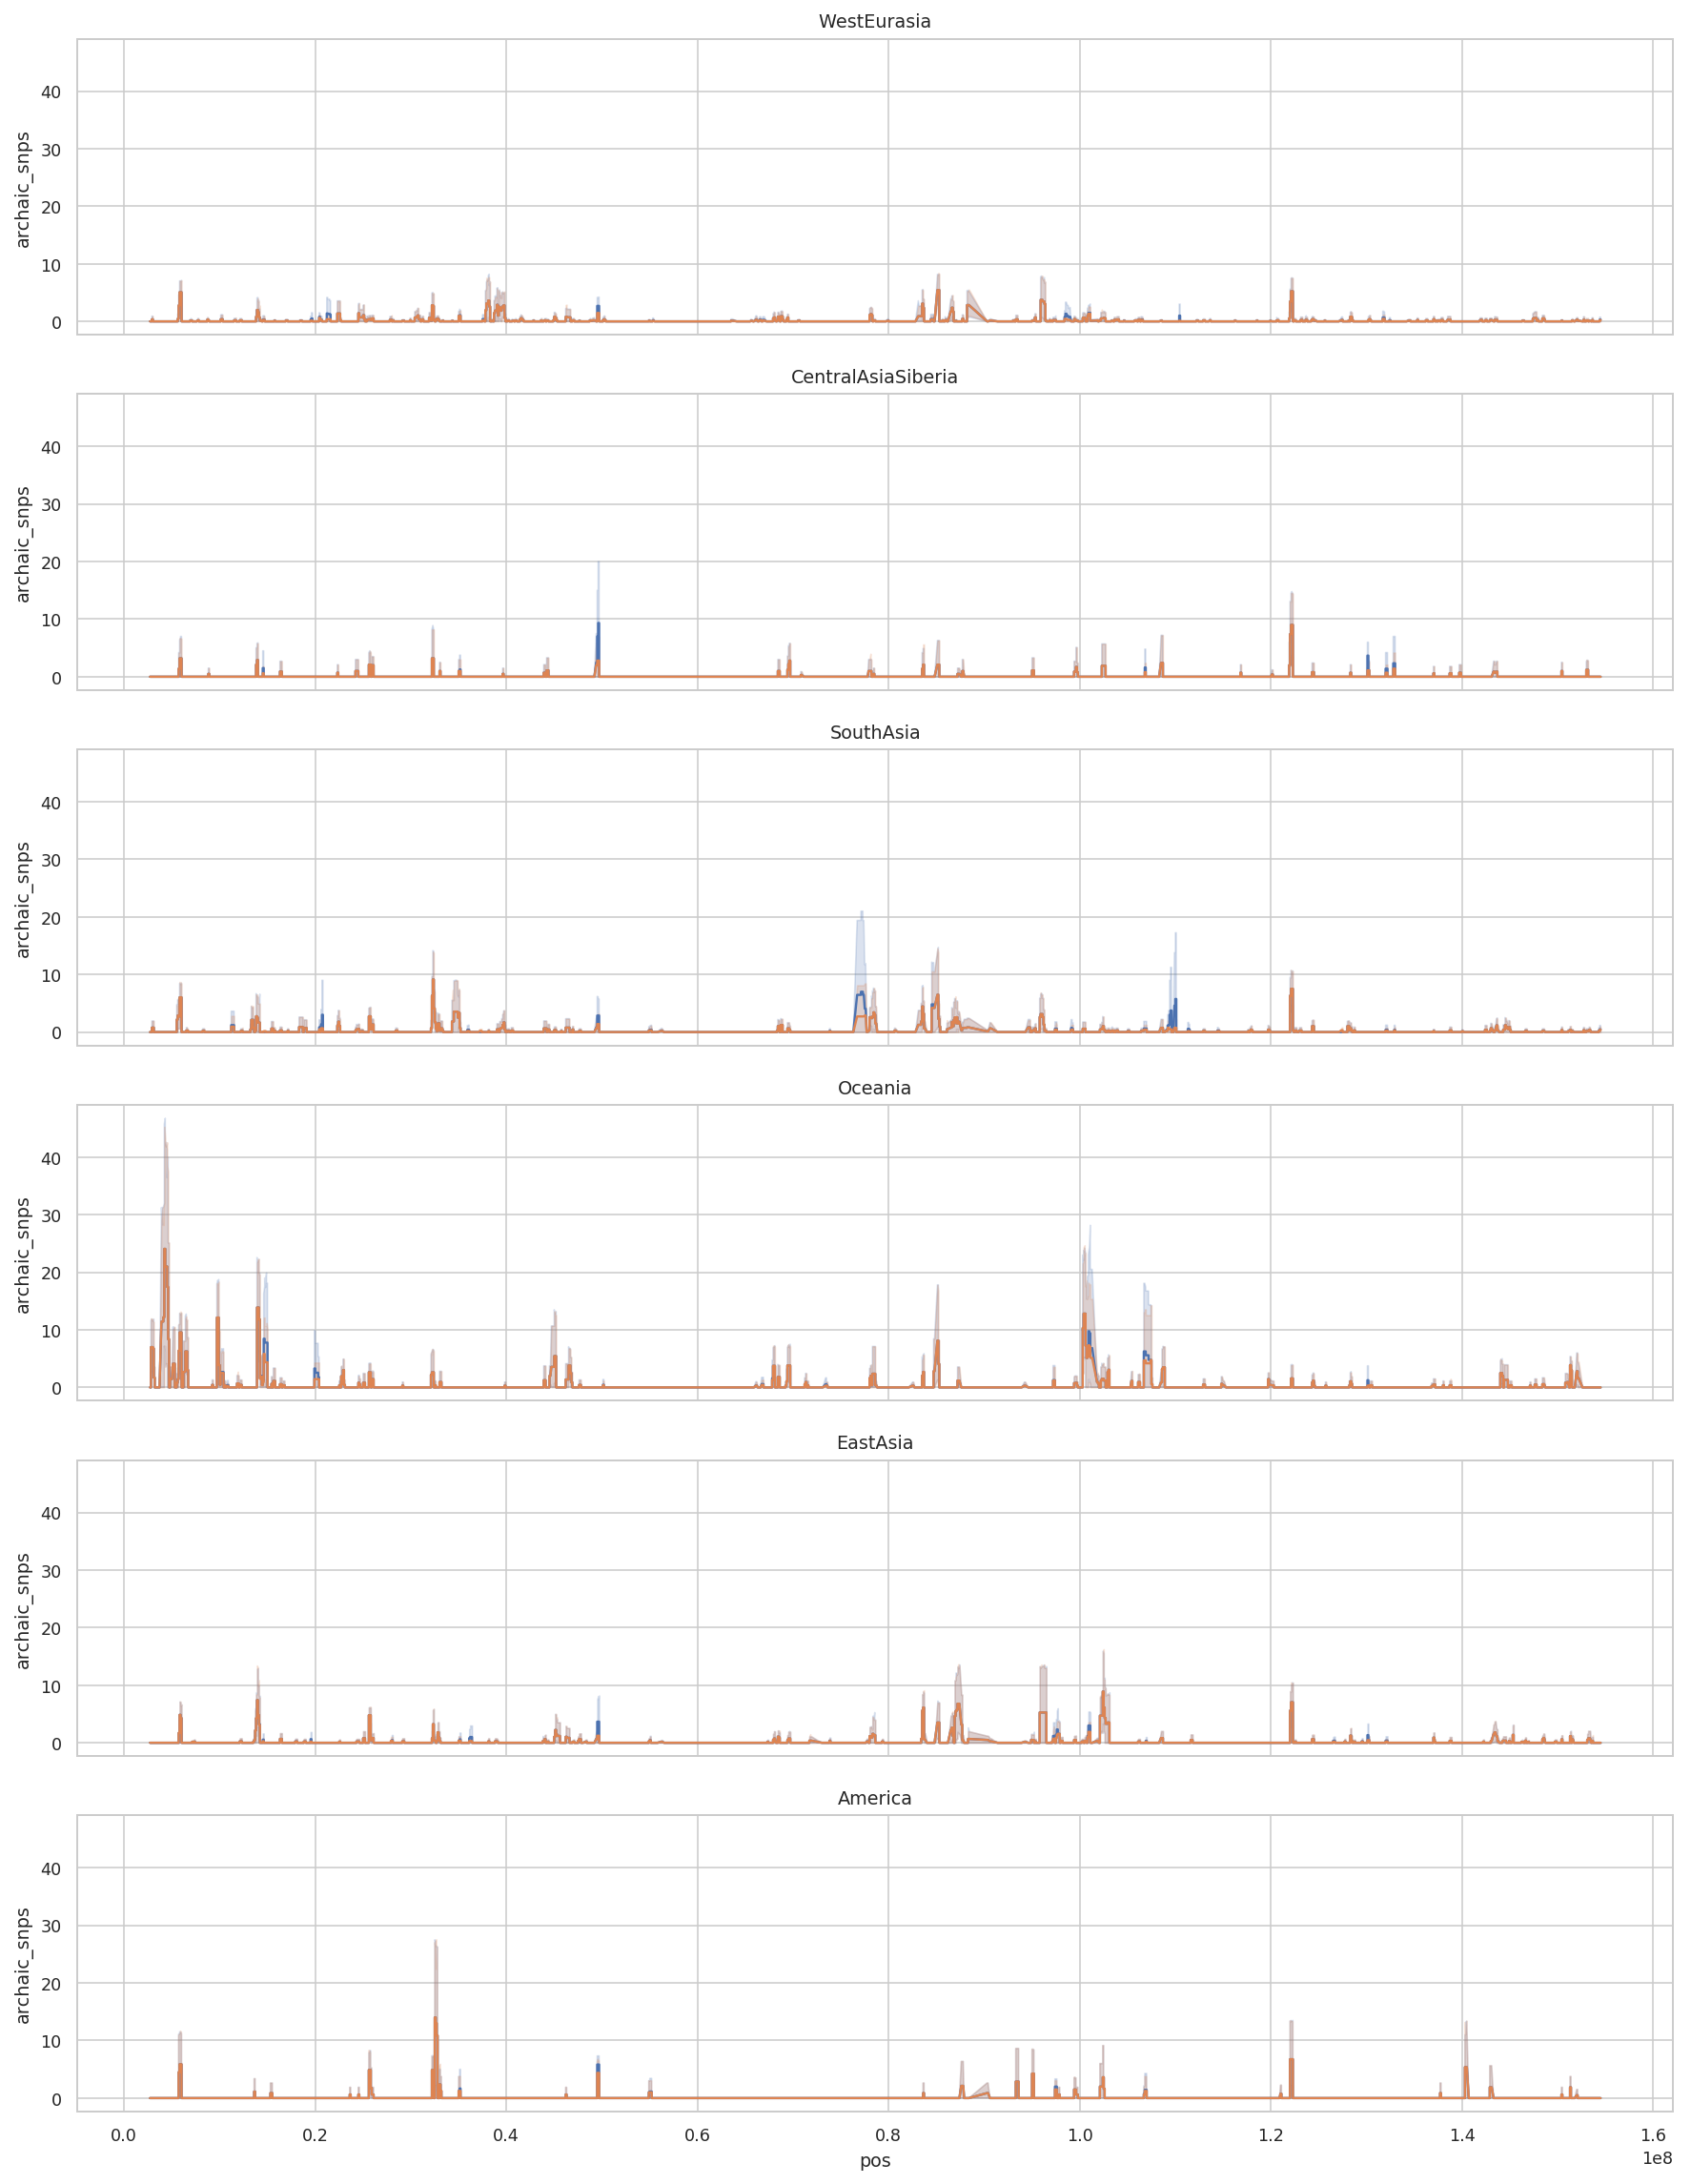

In [26]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])

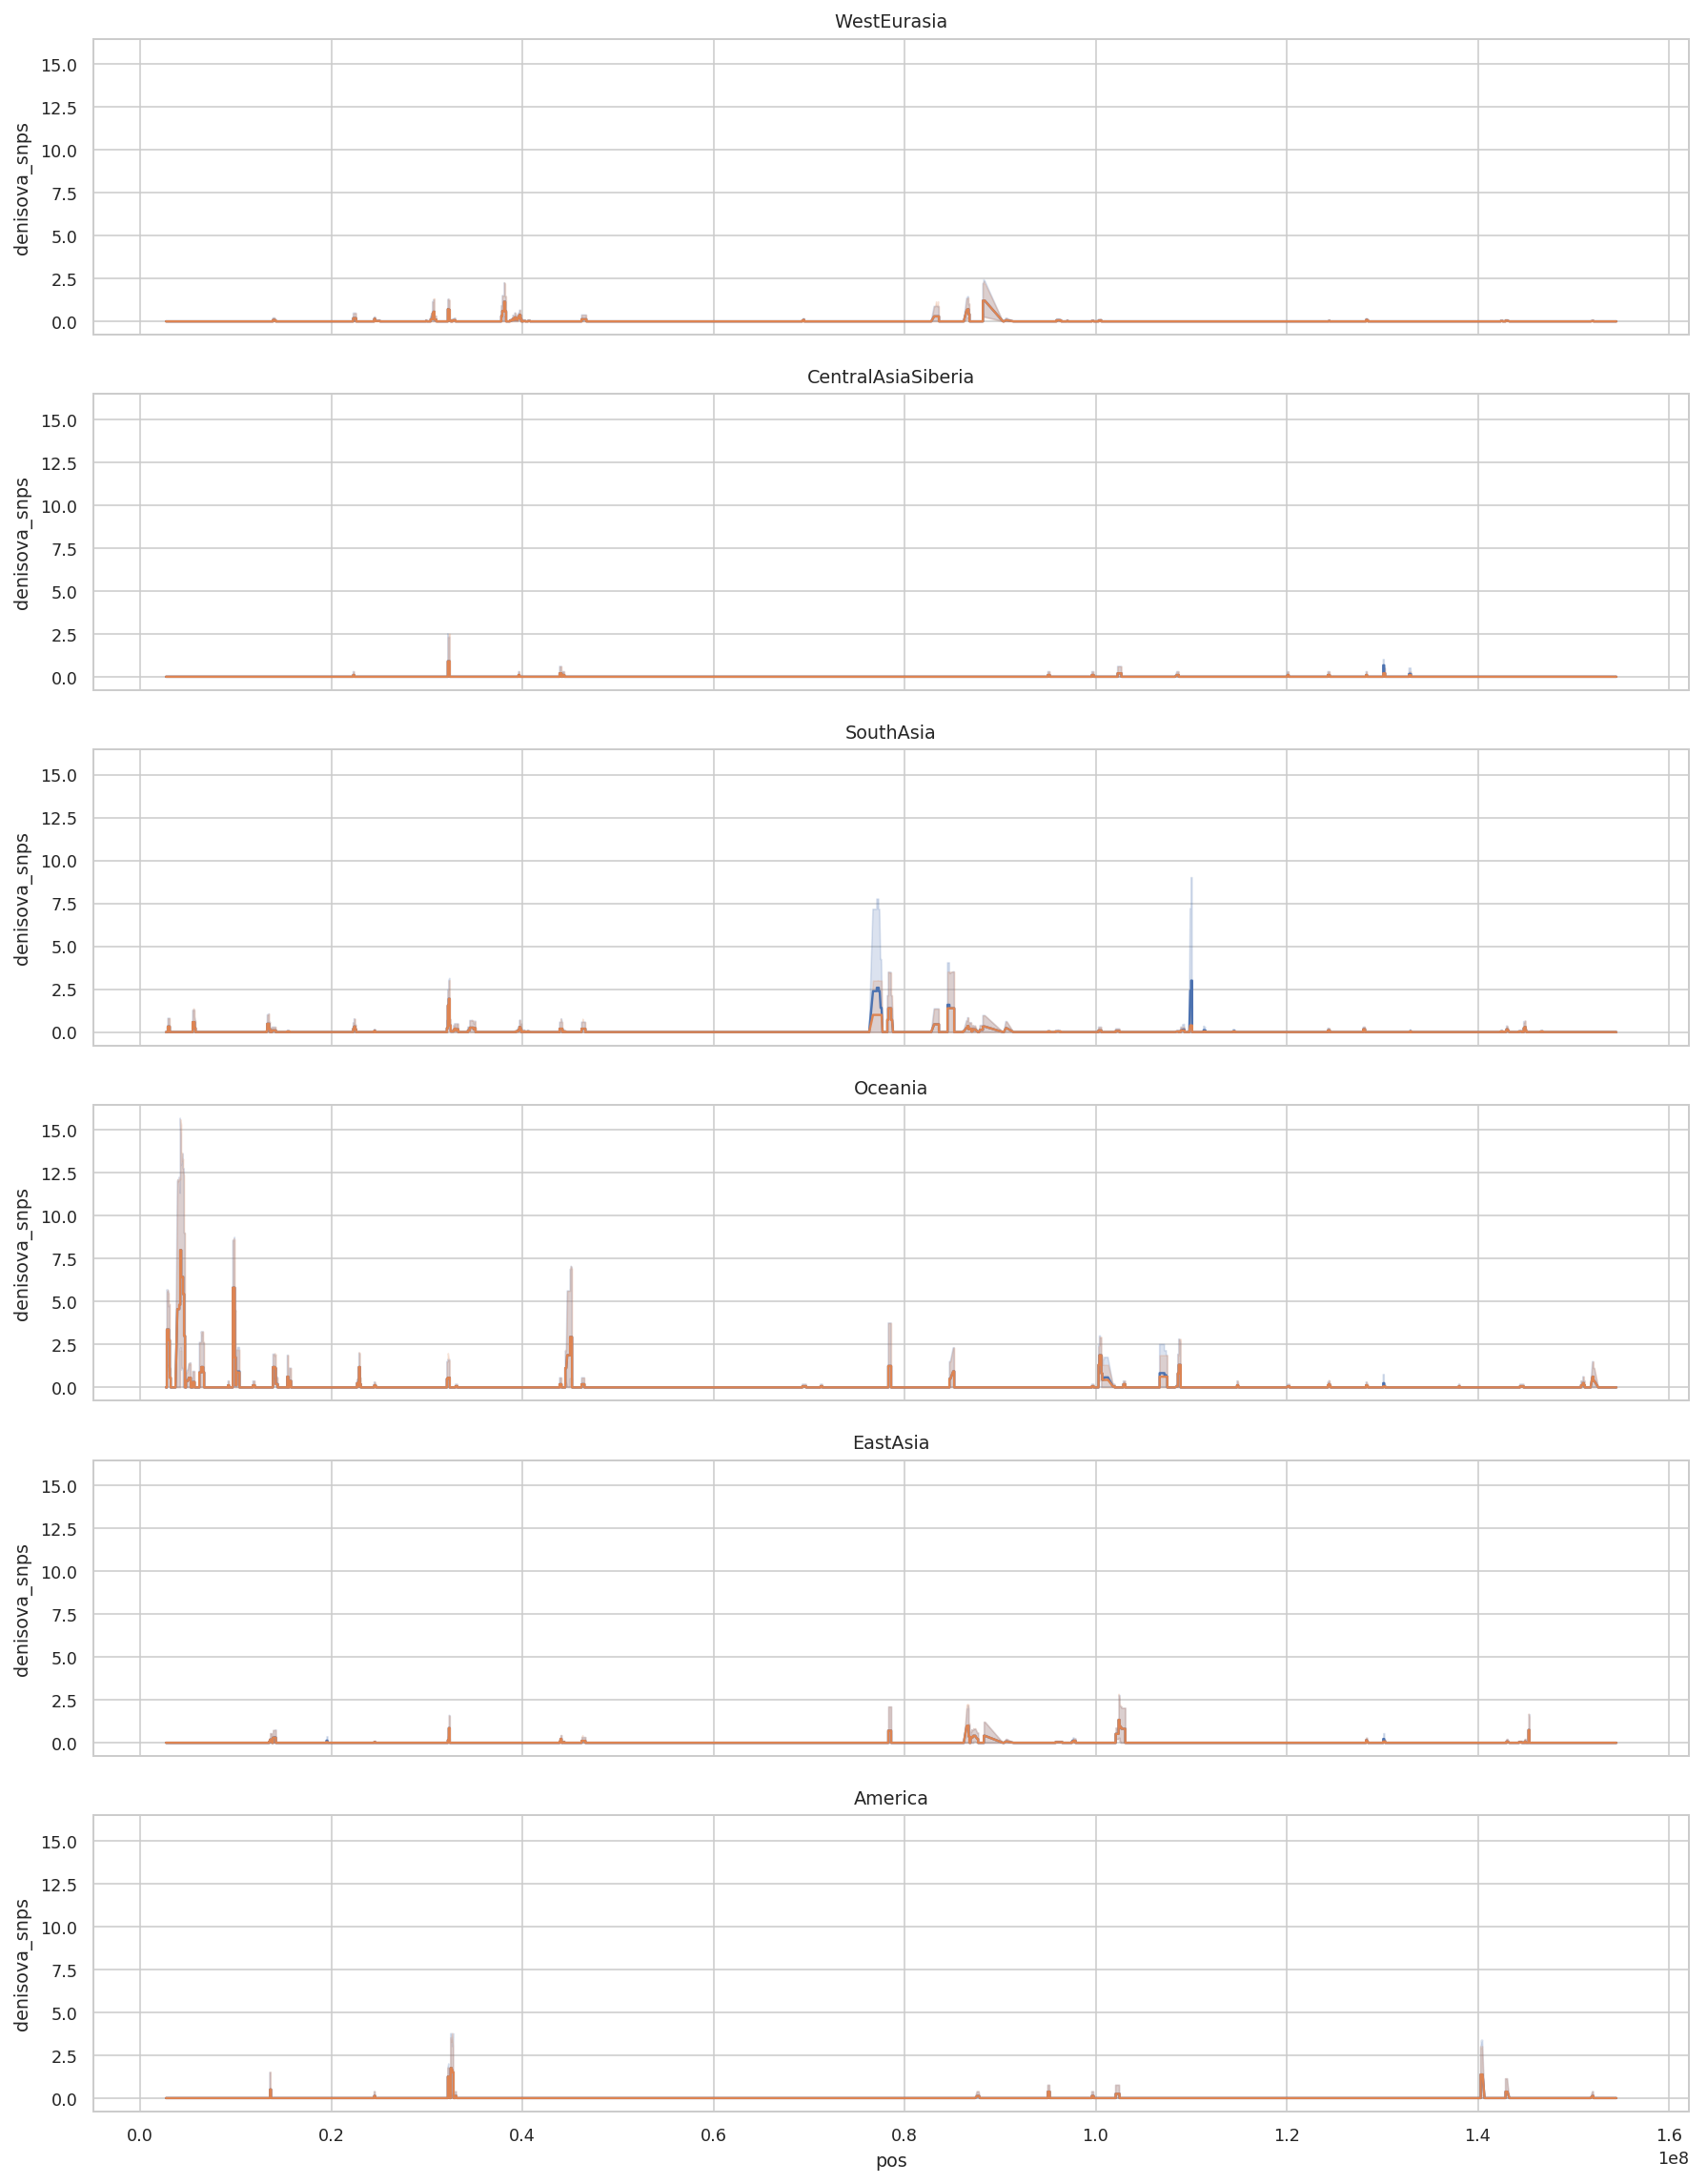

In [27]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])

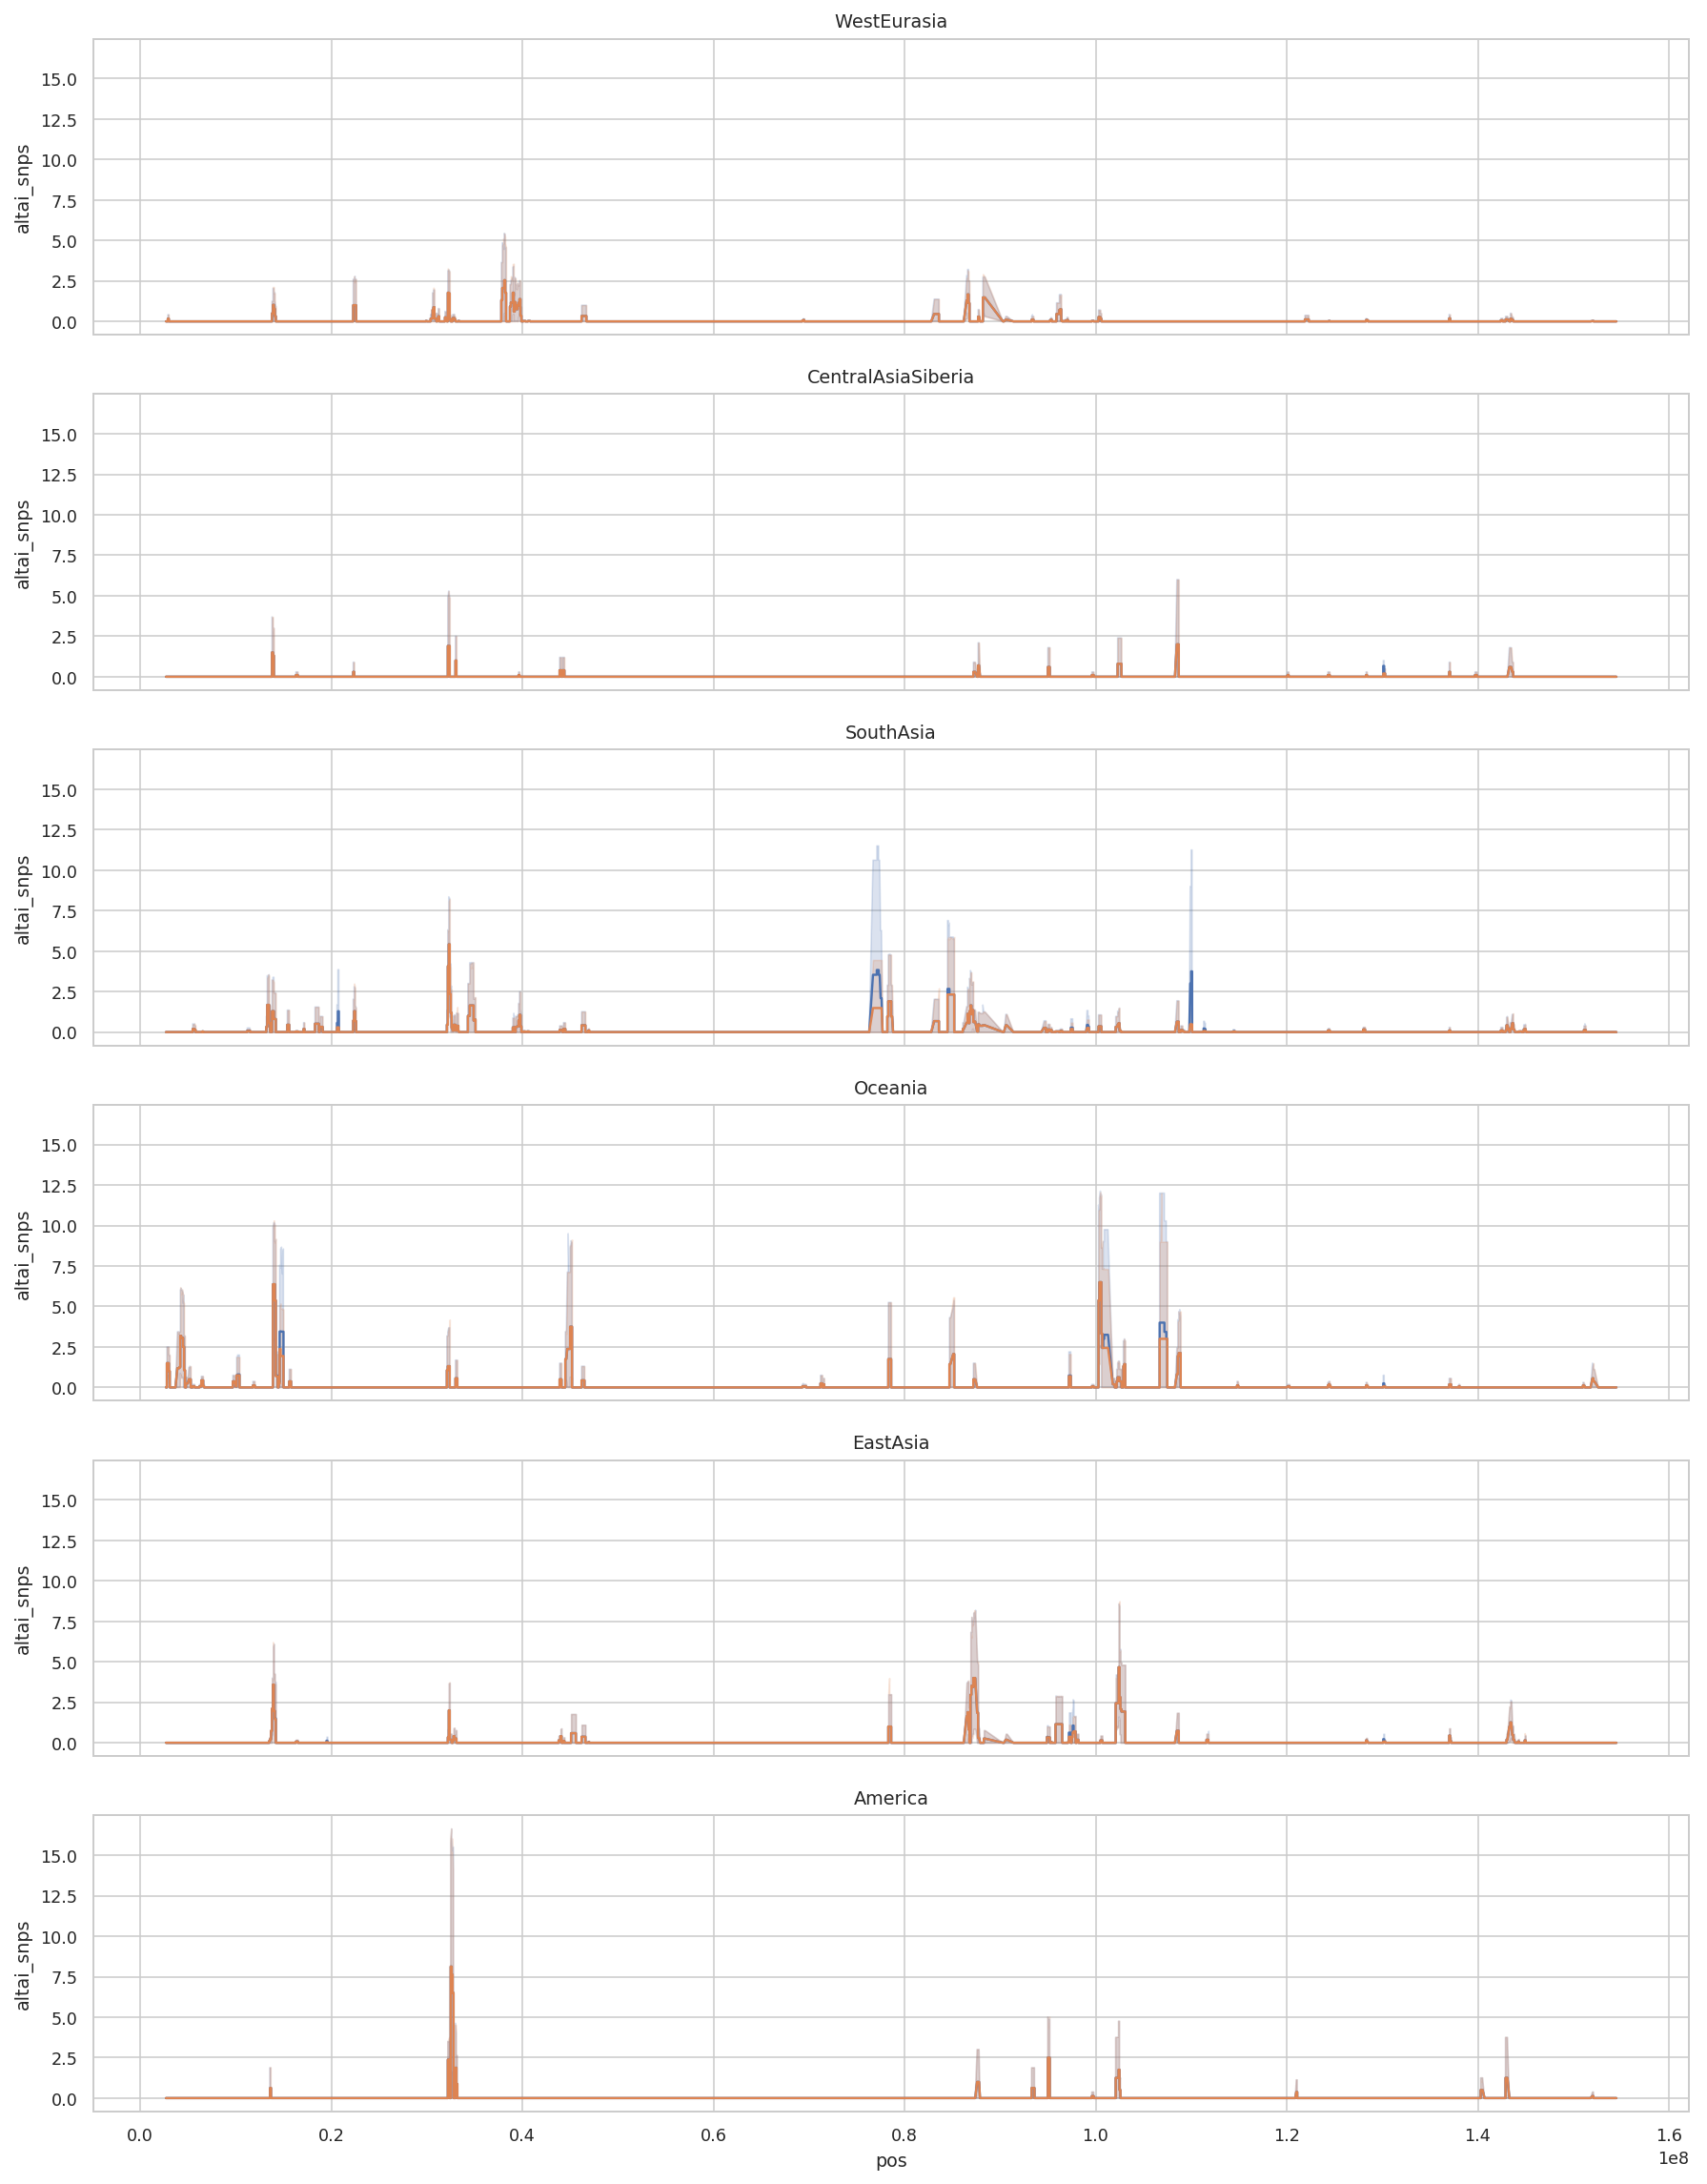

In [28]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])

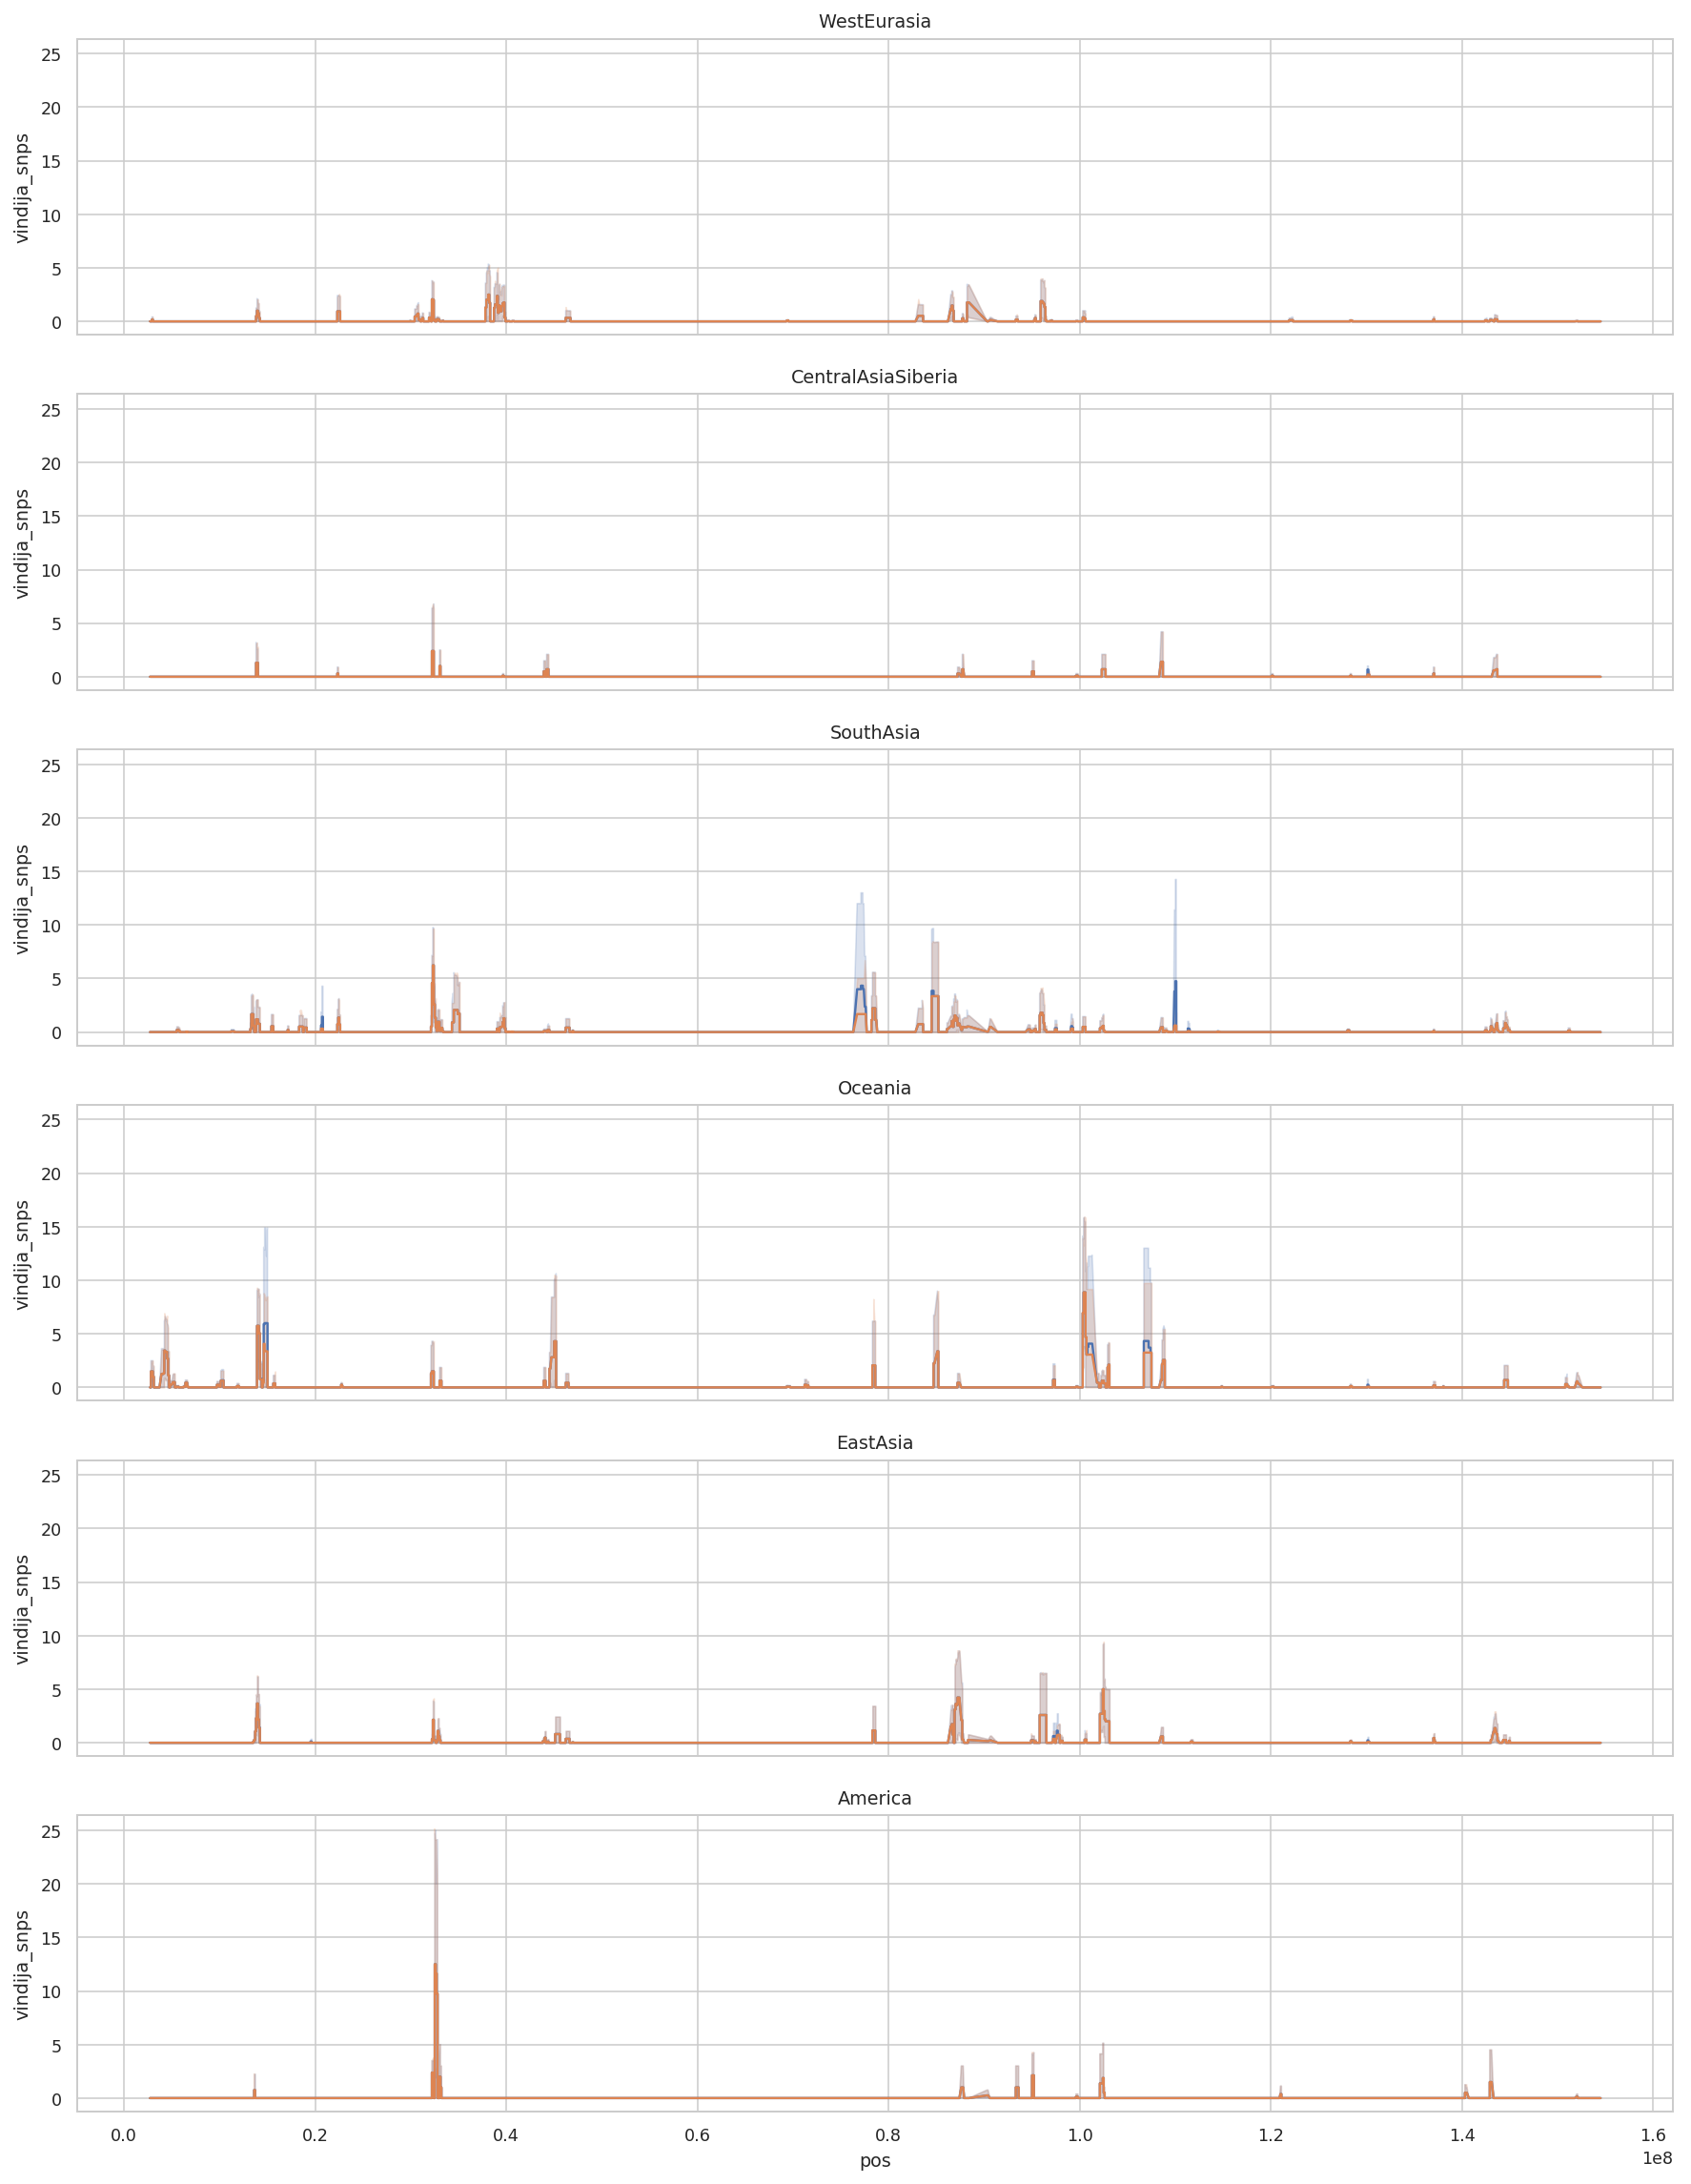

In [29]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])

In [30]:
# plt.figure(figsize=(20,5))
# #plt.plot(merged_data.start, merged_data.admix_prop)
# filtered = lowess(merged_data.admix_prop, merged_data.start, is_sorted=False, frac=0.001, it=0)
# plt.plot(filtered[:,0], filtered[:,1], color='orange')
# plt.show()

## Admixture proportions in stratified by `never_swept`

In [31]:
merged_data.groupby('never_swept')['admix_prop'].agg(['mean', 'count'])

,mean,count
never_swept,,
False,0.003702,51496
True,0.009950,117881


In [32]:
merged_data.groupby('never_swept_af')['admix_prop'].agg(['mean', 'count'])

,mean,count
never_swept_af,,
False,0.004471,54155
True,0.009733,115222


In [33]:
merged_data.groupby(['never_swept', 'never_swept_af'])['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept never_swept_af                  
False       False           0.003702   51496
True        False           0.019357    2659
            True            0.009733  115222

Test difference between `never_swept` `True` and `False`:

In [34]:
scipy.stats.ttest_ind(merged_data.loc[merged_data.never_swept == True, 'admix_prop'],
                      merged_data.loc[merged_data.never_swept == False, 'admix_prop'],
                      nan_policy='omit'
                     )

Ttest_indResult(statistic=15.826293449184677, pvalue=2.2497320167297734e-56)

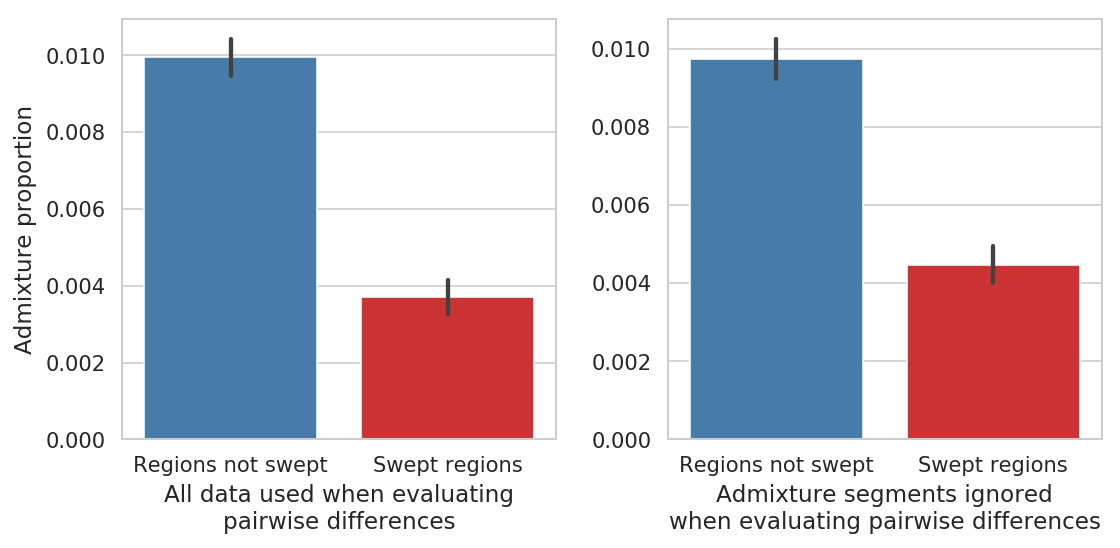

In [35]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            g1 = sns.barplot(x="not_never_swept", y="admix_prop", 
                             data=merged_data.assign(not_never_swept=~merged_data.never_swept), 
                             ax=ax1, n_boot=1000)
            g2 = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g1.set_ylabel("Admixture proportion")
            g2.set_ylabel("")
            g1.set_xlabel("All data used when evaluating\npairwise differences")
            g2.set_xlabel("Admixture segments ignored\nwhen evaluating pairwise differences")
            
            g1.set_xticklabels(['Regions not swept', 'Swept regions'])
            g2.set_xticklabels(['Regions not swept', 'Swept regions'])

            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.pdf'))
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.png'))



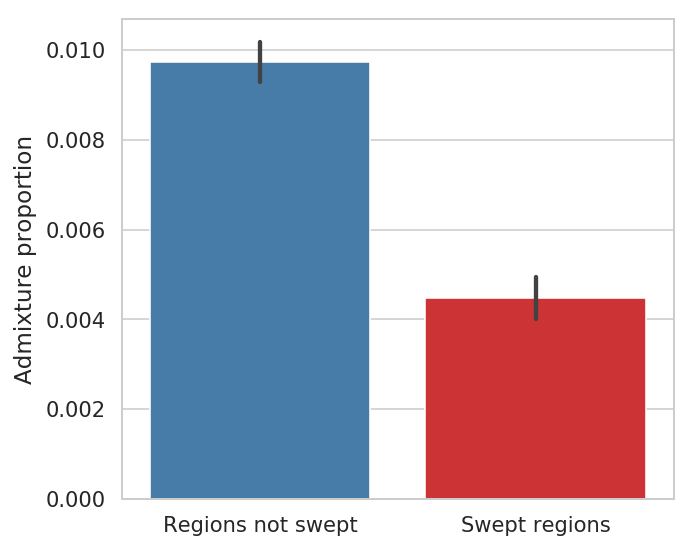

In [36]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, ax2 = plt.subplots(1, figsize=(5,4))
            g = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g.set_ylabel("Admixture proportion")
            g.set_xlabel('')
            g.set_xticklabels(['Regions not swept', 'Swept regions'])
                        
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions_af.pdf'))


## Admixture proportions only in windows that are `swept` in some males and not in others

In [37]:
df = (merged_data.loc[lambda df: (df.partial_sweep_win == True),# & (df.conserv_swept_group != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept', 'admix_prop']]
      
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
      
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept'], 
                 var_name='call',
                value_name='is_swept')
          )

df_af = (merged_data.loc[lambda df: (df.partial_sweep_win_af == True),# & (df.conserv_swept_group_af != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept_af', 'admix_prop']]
         
         
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept_af']) == set([False, True]))
         
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept_af'], 
                 var_name='call',
                value_name='is_swept')
          )

plot_df = pandas.concat([df, df_af])
plot_df['region_1'] = plot_df.region_1.astype('category').cat.set_categories(
    ['Africa', 'WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'Oceania', 'EastAsia', 'America'])

plot_df = plot_df.loc[lambda df: df.region_1 != 'Africa']


# plot_df['region_1'] 
plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

plot_df.head()

,indiv_1,region_1,start,admix_prop,call,is_swept
0,B_Australian-4,Oceania,10200000,0.0,swept,False
1,B_Australian-4,Oceania,10300000,0.0,swept,False
2,B_Australian-4,Oceania,10400000,0.0,swept,False
3,B_Australian-4,Oceania,10500000,0.0,swept,False
4,B_Australian-4,Oceania,10600000,0.0,swept,False


In [38]:
df = plot_df.groupby(['call', 'is_swept'])['admix_prop'].agg(['mean', 'sem'])
df

mean       sem
call     is_swept                    
swept    False     0.005676  0.000352
         True      0.000103  0.000041
swept_af False     0.005791  0.000350
         True      0.000606  0.000139

Reduction in admixture proportion in ECHs compared to ECHs in the same windows

In [39]:
(df.loc[('swept', False), 'mean'] - df.loc[('swept', True), 'mean']) / df.loc[('swept', False), 'mean']

0.98189987131767809

Plots are based on this many 100kb windows along the chromosome:

In [40]:
plot_df.start.drop_duplicates().size

455

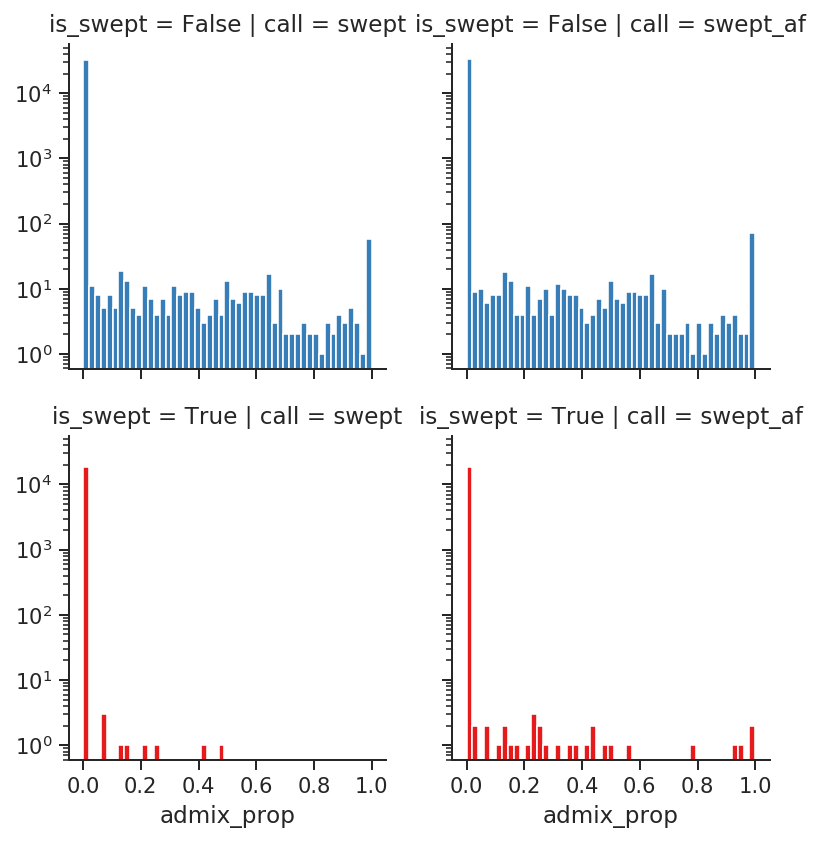

In [41]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.FacetGrid(row='is_swept', col='call', hue='is_swept', data=plot_df, sharex=True, sharey=True)
            g.map(plt.hist, 'admix_prop', bins=numpy.linspace(0, 1, 50))
            
#             g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
#             g.set_ylabel('Mean admixture proportion')
#             g.set_xlabel('')
#             g.set_xticklabels(['All data used when evaluating\npairwise differences', 
#                                'Admixture segments ignored\nwhen evaluating pairwise distances'])
            
            [ax.set_yscale('log') for ax in g.axes.flat]

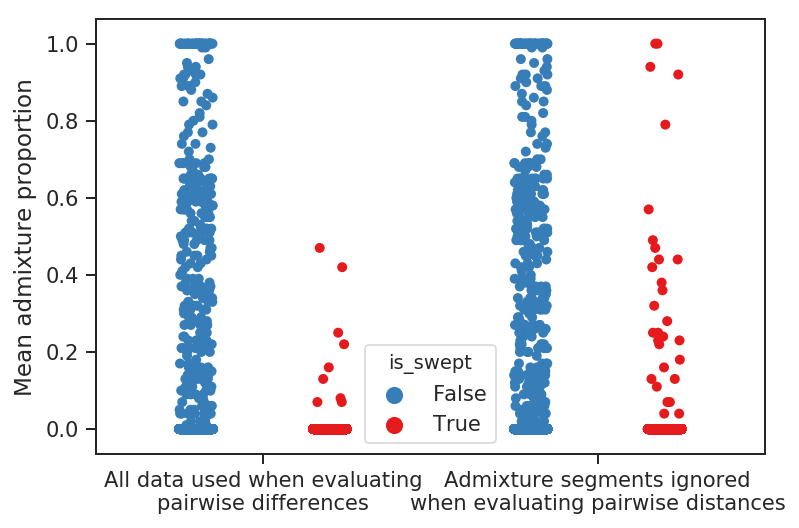

In [42]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
#            g.set_yscale('log')

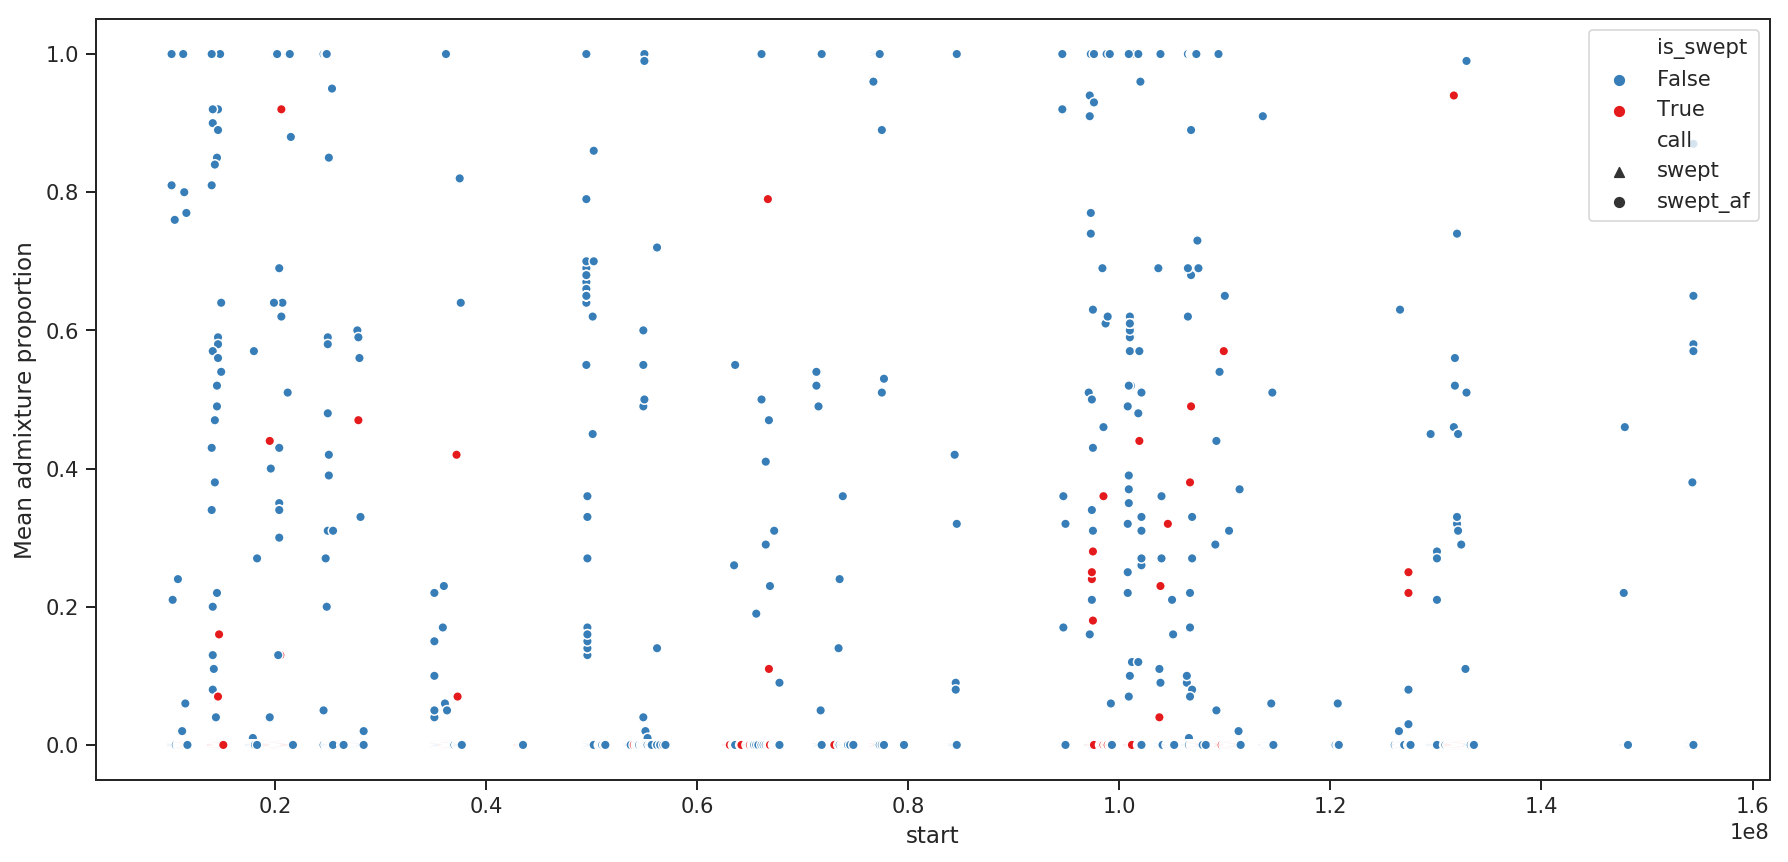

In [66]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            plt.figure(figsize=(15,7))
            g = sns.scatterplot(x='start', y='admix_prop', style='call', hue='is_swept', markers=['^', 'o'], data=plot_df)
            g.set_ylabel('Mean admixture proportion')

In [71]:
pandas.pivot_table(plot_df, index=['start', 'admix_prop'], columns='is_swept')

DataError: No numeric types to aggregate

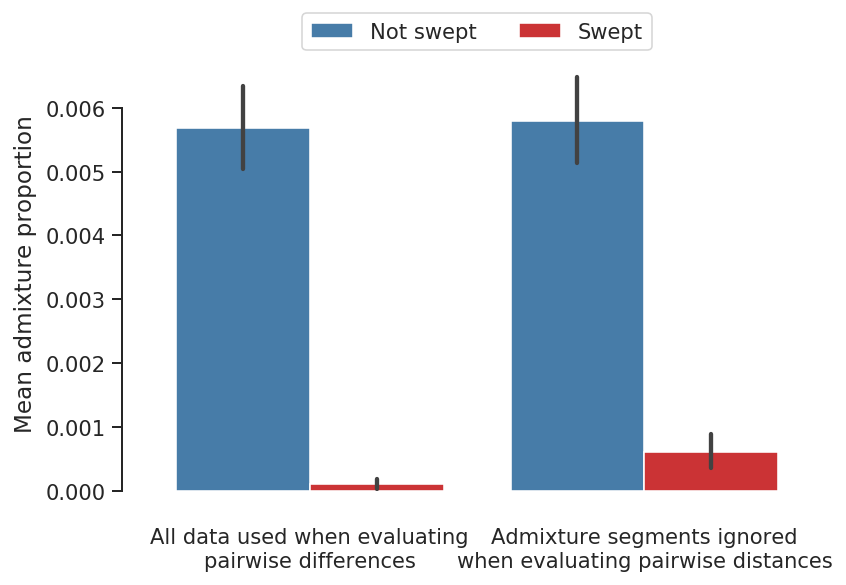

In [44]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='call', y='admix_prop', hue='is_swept', data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()

            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',
                     ncol=2
                    )
            
            sns.despine(trim=True, offset=10)

            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            ) # labels along the bottom edge are off
            plt.gca().axes.spines['bottom'].set_visible(False)
                
            plt.savefig(str(figures_dir / 'admix_prop_by_call.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call.png'))

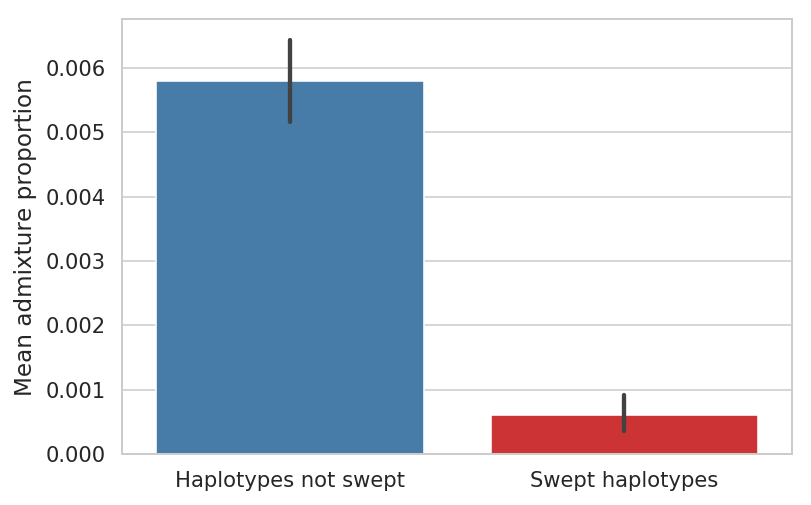

In [45]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='is_swept', y='admix_prop', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af']
                           )
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['Haplotypes not swept', 'Swept haplotypes'])

            plt.savefig(str(figures_dir / 'admix_prop_af.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_af.png'))

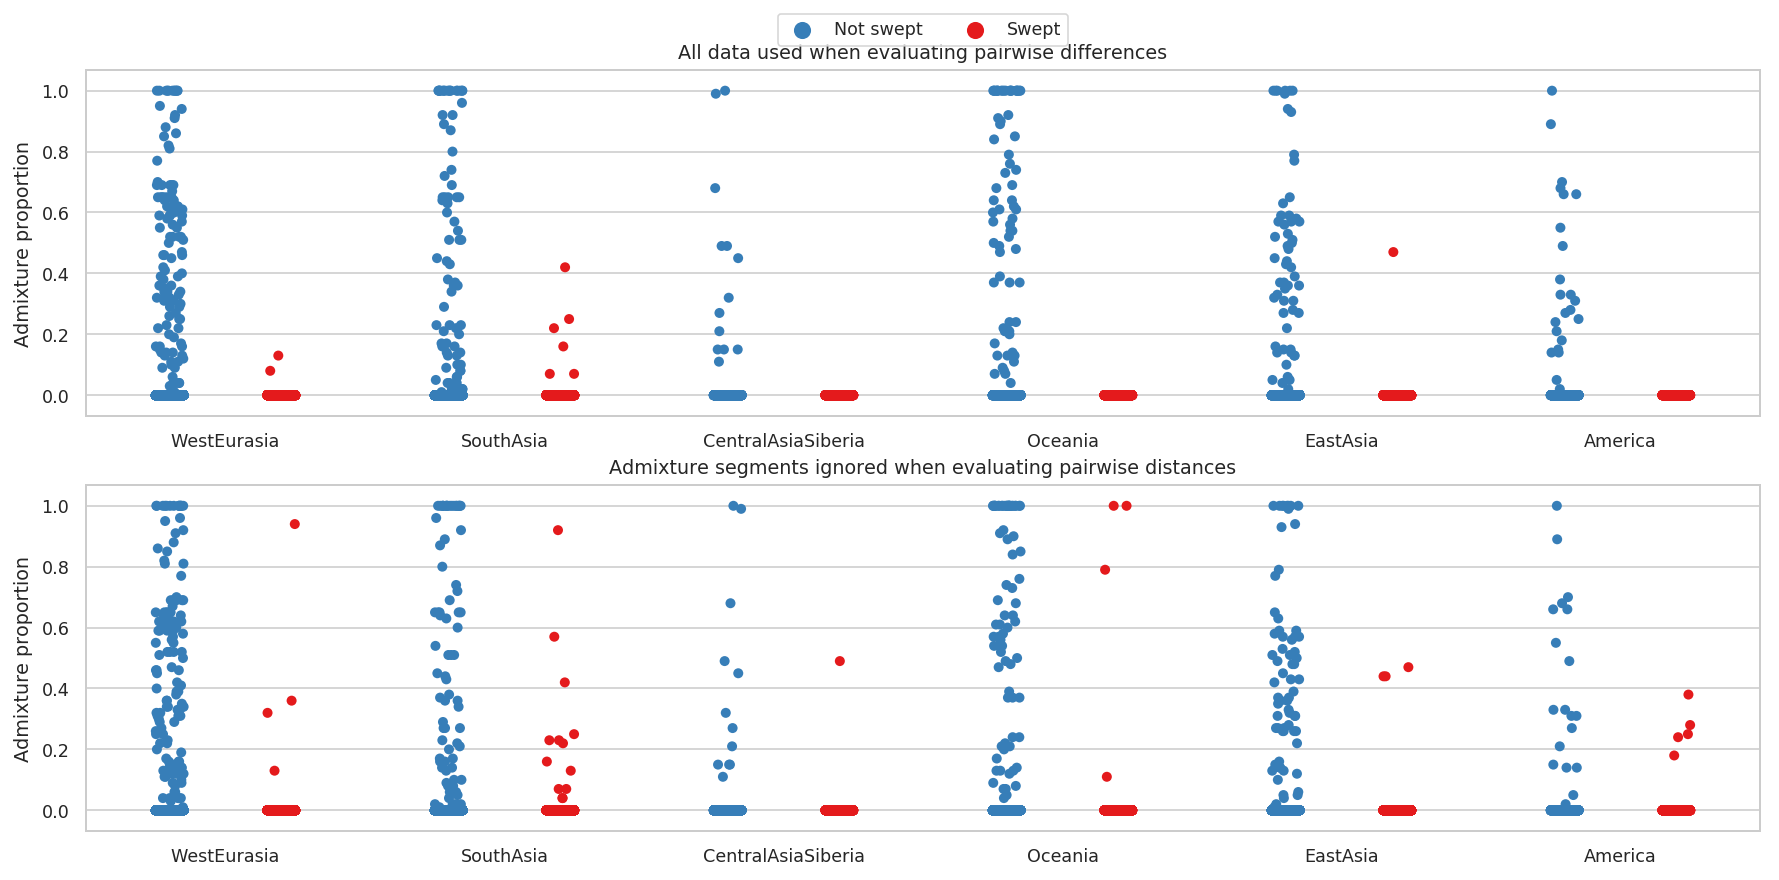

In [46]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharey=True)

            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

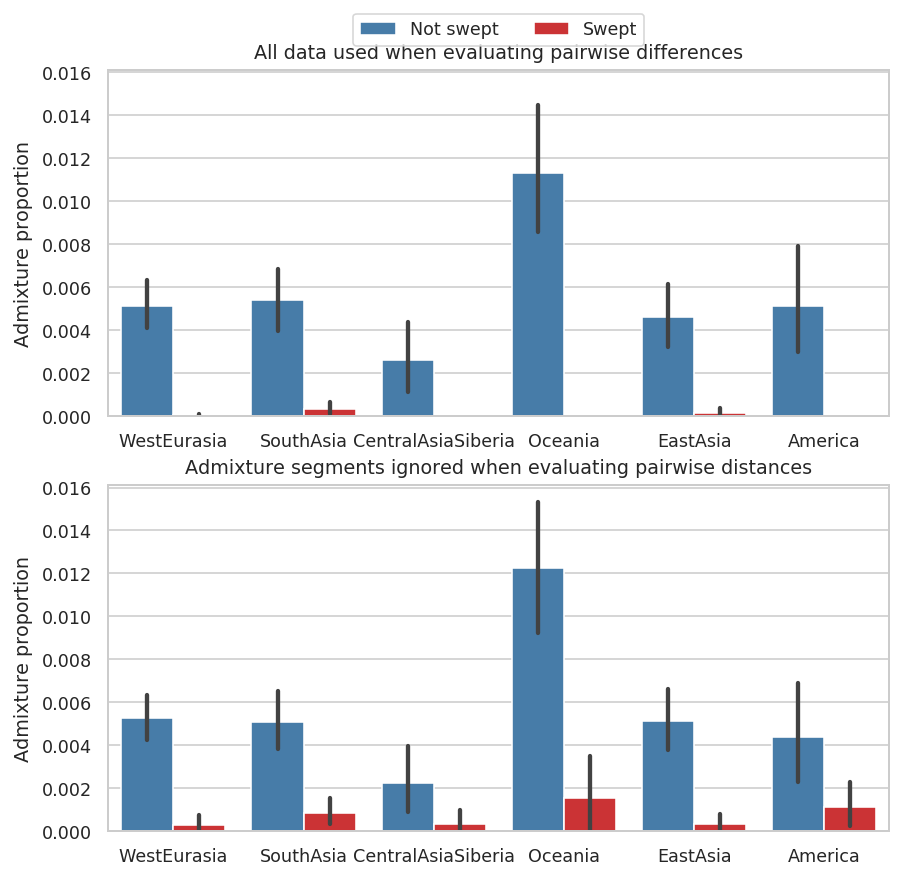

In [47]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharey=True)

            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.png'))

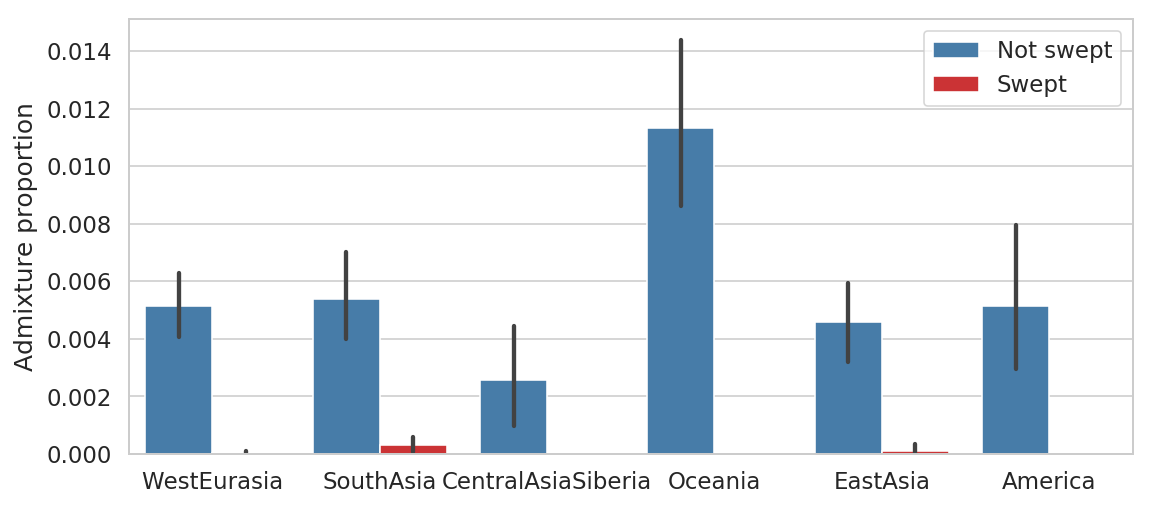

In [48]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.3):
            
            fig, ax = plt.subplots(1, 1, figsize=(9, 4))
                
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )

            g.legend(handles, ['Not swept', 
                               'Swept',
                              ],
                     loc='upper right',
                     ncol=1
                    )
            plt.savefig(str(figures_dir / 'admix_prop_by_region.pdf'))


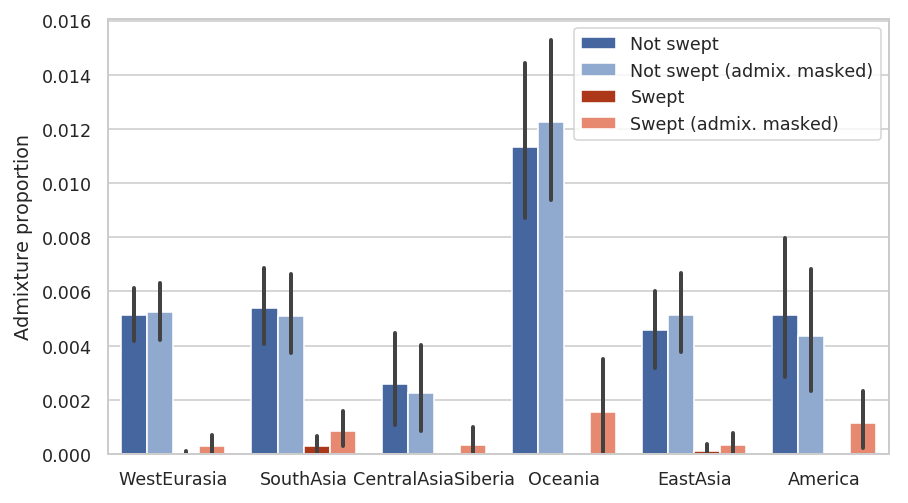

In [49]:
with sns.color_palette(["#3662AE", "#86A7D9", "#C52900", "#FB7D5D"]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))

            g = sns.barplot(x='region_1', y='admix_prop', hue='label', 
                            data=plot_df.assign(label=plot_df.call.astype(str) + "_" + plot_df.is_swept.astype(str)), 
                            hue_order=['swept_False', 'swept_af_False', 'swept_True', 'swept_af_True'],
                            ax=ax1,
                            errwidth=2,
                            #width = .8
                           )

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 
                               'Not swept (admix. masked)',
                               'Swept',
                               'Swept (admix. masked)',
                              ],
                     #bbox_to_anchor=(1., 1.0),  loc='upper left',
                     loc='upper right',
#                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=1
                    )

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region_version2.pdf'))

Admixture proportions:

In [50]:
(plot_df
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
)

mean       sem
call     region_1           is_swept                    
swept    WestEurasia        False     0.005134  0.000540
                            True      0.000036  0.000026
         SouthAsia          False     0.005397  0.000753
                            True      0.000306  0.000146
         CentralAsiaSiberia False     0.002584  0.000874
                            True      0.000000  0.000000
         Oceania            False     0.011325  0.001518
                            True      0.000000  0.000000
         EastAsia           False     0.004593  0.000717
                            True      0.000119  0.000119
         America            False     0.005127  0.001285
                            True      0.000000  0.000000
swept_af WestEurasia        False     0.005244  0.000540
                            True      0.000295  0.000179
         SouthAsia          False     0.005096  0.000717
                            True      0.000850  0.000323
         CentralAsiaSiberia False     0.002237  0.000802
                            True      0.000327  0.000327
         Oceania            False     0.012244  0.001561
                            True      0.001536  0.000859
         EastAsia           False     0.005140  0.000736
                            True      0.000338  0.000195
         America            False     0.004362  0.001201
                            True      0.001141  0.000525

In the admixture filtered analysis, confidence intervals for mean admixture proportions overlap, or nearly overlap zero. Add to that that Laurit's method has a false positive rate of 5-10%.

In [51]:
(plot_df.loc[lambda df: (df.call=='swept_af') & (df.is_swept==True)]
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
 .reset_index()
 .assign(non_zero=lambda df: df['mean']-1.96*df['sem'])
)

,call,region_1,is_swept,mean,sem,non_zero
0,swept_af,WestEurasia,True,0.000295,0.000179,-0.000056
1,swept_af,SouthAsia,True,0.000850,0.000323,0.000218
2,swept_af,CentralAsiaSiberia,True,0.000327,0.000327,-0.000314
3,swept_af,Oceania,True,0.001536,0.000859,-0.000149
4,swept_af,EastAsia,True,0.000338,0.000195,-0.000045
5,swept_af,America,True,0.001141,0.000525,0.000113


### Chromosome wide admixture proportion excluding the swept haplotypes we call:

Compute mean admixture of each 100kb window when sweept windows are excluded and then compute chromosome mean:

In [52]:
chrom_admix_without_sweeps = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix_without_sweeps

,mean,sem,lower,upper
admix_prop,0.00642,0.000882,0.004692,0.008148


In [53]:
chrom_admix = (plot_df
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix

,mean,sem,lower,upper
admix_prop,0.003954,0.00052,0.002936,0.004972


In [54]:
(chrom_admix_without_sweeps['mean'] - chrom_admix['mean']) / chrom_admix_without_sweeps['mean']

admix_prop    0.384096
Name: mean, dtype: float64

Same but by region:

In [55]:
chrom_admix_without_sweeps_by_region = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_without_sweeps_by_region

,mean,sem,lower,upper
region_1,,,,
WestEurasia,0.005502,0.000912,0.003715,0.007289
SouthAsia,0.006840,0.001250,0.004391,0.009289
CentralAsiaSiberia,0.003236,0.001436,0.000423,0.006050
Oceania,0.011575,0.002137,0.007387,0.015764
EastAsia,0.005231,0.001242,0.002797,0.007665
America,0.003976,0.001853,0.000345,0.007607


Same computation but inlcuding all windows for al individuals:

In [56]:
chrom_admix_by_region = (plot_df
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_by_region

,mean,sem,lower,upper
region_1,,,,
WestEurasia,0.003596,0.000554,0.002509,0.004683
SouthAsia,0.003646,0.000551,0.002566,0.004725
CentralAsiaSiberia,0.001468,0.000594,0.000304,0.002631
Oceania,0.008838,0.001740,0.005429,0.012248
EastAsia,0.003227,0.000673,0.001909,0.004545
America,0.003098,0.001297,0.000556,0.005641


How much higher would the chromosome average admixture level be if we take out swept haplotypes:

In [57]:
(chrom_admix_without_sweeps_by_region['mean'] - chrom_admix_by_region['mean']) / chrom_admix_without_sweeps_by_region['mean']

region_1
WestEurasia           0.346371
SouthAsia             0.467020
CentralAsiaSiberia    0.546471
Oceania               0.236456
EastAsia              0.383098
America               0.220769
Name: mean, dtype: float64

### Plot below is not for use but only for keeping as template in case I do a more thorough analysis on Laurits larger Papuan set.

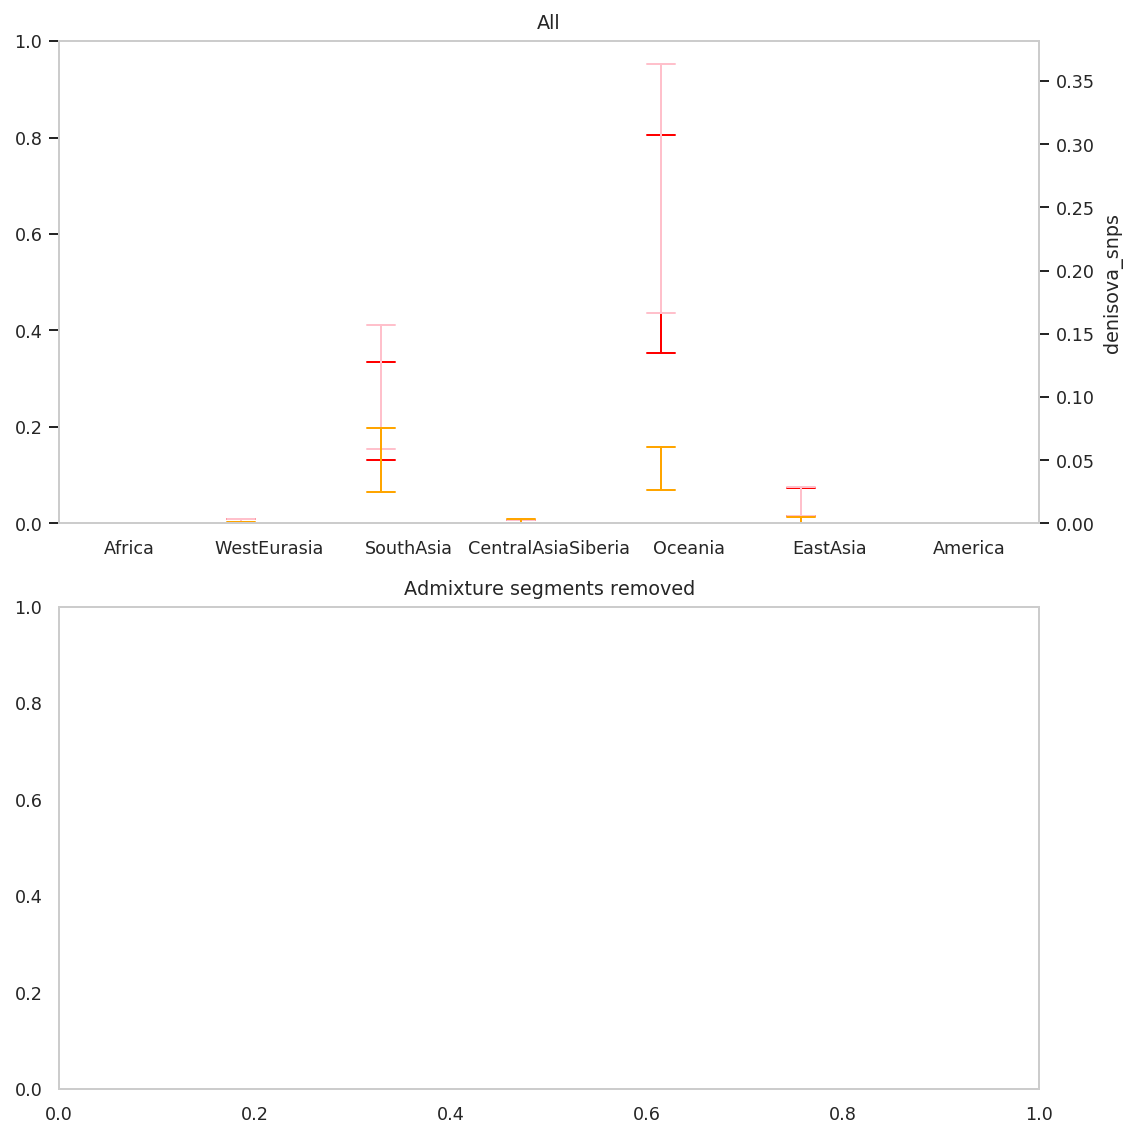

In [58]:
sweep_and_admix_data_subset = (merged_data
                               .groupby(['start'])
                               .filter(lambda df: df.swept.sum() > 0)
                              )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept', 
#                             data=merged_data.loc[lambda df: (df.never_win_swept == False) & (df.conserv_swept_group != 'ambig')], 
#                             ax=ax1, n_boot=1000)
            ax1.grid(False)
            ax1.set_title("All")

            extra_ax = ax1.twinx()
            sns.barplot(x='region_1', y='altai_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="red")
            sns.barplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="pink")
            sns.barplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="orange")
            extra_ax.grid(False)
            extra_ax.legend_.remove()

            for item in g.get_xticklabels():
                item.set_rotation(25)

#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
#                 data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
#                             ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Admixture segments removed")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

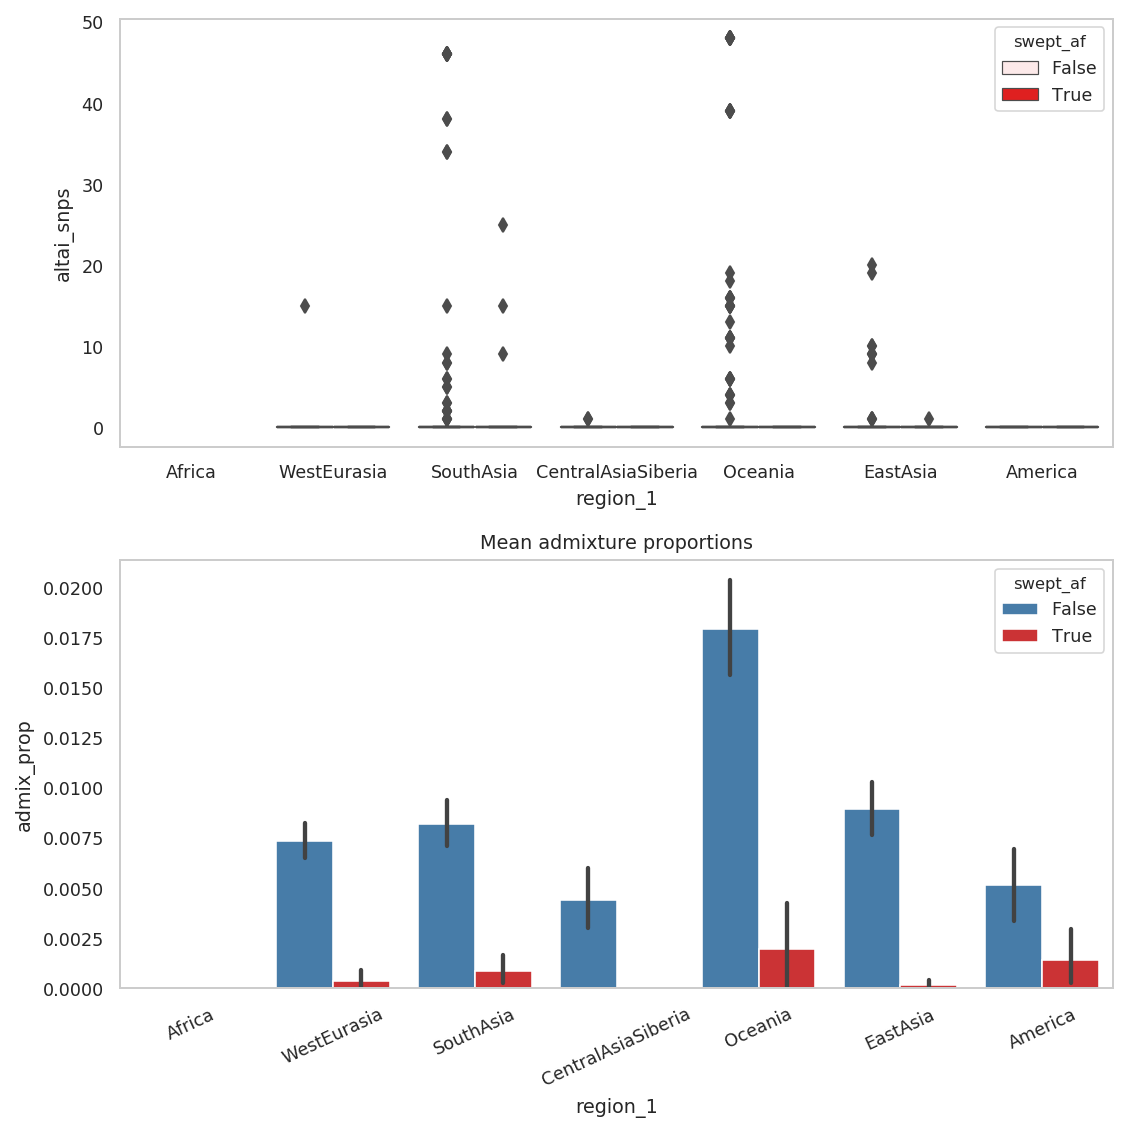

In [59]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

            ax1.grid(False)
            sns.boxplot(x='region_1', y='altai_snps', hue='swept_af', data=sweep_and_admix_data_subset, ax=ax1,
                         color="red")
#             sns.boxplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="pink")
#             sns.boxplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="orange")

            for item in g.get_xticklabels():
                item.set_rotation(25)

            g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
                data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
                            ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Mean admixture proportions")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

### Admixture proportion with distance from peaks (not finished)

In [60]:
sweep_peaks = pandas.read_hdf(results_dir / "sweep_peaks.hdf").assign(chrom='X').sort_values(by='start')
len(sweep_peaks)

29

In [61]:
male_x_admix_segments = pandas.read_hdf(results_dir / 'male_x_admix_segments.hdf').sort_values(by='start')
len(male_x_admix_segments)

1359

In [62]:
non_ovl_admix_segm = GenomicIntervals.interval_diff(male_x_admix_segments, sweep_peaks)
len(non_ovl_admix_segm)

1360

In [63]:
GenomicIntervals.interval_intersect(non_ovl_admix_segm, sweep_peaks)

,index,start,end,chrom
0,0,14642000,14800000,X
1,1,100390000,100491000,X
2,2,100390000,100579000,X
3,3,100394000,100560000,X
4,4,100470000,100509000,X
5,5,100477000,100514000,X
6,6,100488000,100682000,X
7,7,100488000,100682000,X
8,8,100598000,100682000,X
9,9,100851000,101057000,X


In [64]:
GenomicIntervals.interval_intersect(non_ovl_admix_segm, sweep_peaks)

,index,start,end,chrom
0,0,14642000,14800000,X
1,1,100390000,100491000,X
2,2,100390000,100579000,X
3,3,100394000,100560000,X
4,4,100470000,100509000,X
5,5,100477000,100514000,X
6,6,100488000,100682000,X
7,7,100488000,100682000,X
8,8,100598000,100682000,X
9,9,100851000,101057000,X


In [65]:
GenomicIntervals.interval_distance(non_ovl_admix_segm, sweep_peaks)

AssertionError: query and annotations coordinates overlap

## Which swept windows have admixture when calling with admix filter?

In [ ]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_data.loc[lambda df: (df.never_win_swept_af == False) & \
#                            (df.conserv_swept_group_af != 'ambig') &  \
                            (df.admix_prop > 0)]
            .sort_values(by=['admix_prop'], ascending=False))

## Correlation between proportion of windows swept and admixture proportion in each individual

There is a relation between amount swept and admixtue, as would be expected if sweeps displace admixture.

In [ ]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
#           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.pdf'))


The same but with the following two outliers removed:

In [ ]:
print(plot_df.loc[plot_df.admix_prop > 0.03])

In [ ]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

ax1.set_ylim(0, 0.03)
ax1.set_xlim(0, 0.2)
ax2.set_ylim(0, 0.03)
ax2.set_xlim(0, 0.2)

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.pdf'))


In [ ]:
g = sns.lmplot(data=plot_df, 
               x='swept', y='admix_prop', hue='region_1', 
               fit_reg=False, palette='Set1')